In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from scipy import linalg
import scipy.integrate as integrate
from scipy.special import gamma
import time

from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture._gaussian_mixture import _estimate_log_gaussian_prob, _compute_precision_cholesky, _estimate_gaussian_covariances_full
from sklearn.utils import check_random_state
from sklearn import cluster
from sklearn.model_selection import KFold

from sklearn.feature_selection import mutual_info_regression

In [2]:
class my_GMM(GMM):
    """
    Custom GMM class based on the sklearn GMM class.
    This allows to work with a GMM with fixed parameters, without fitting it.
    It also allows to estimate MI with a certain number of MC samples.
    The different initialisation types are dealt with separately.
    """
    def __init__(self,
                 n_components=1,
                 covariance_type="full",
                 tol=1e-5,
                 reg_covar=1e-6,
                 max_iter=100,
                 n_init=1,
                 init_params="random",
                 random_state=None,
                 warm_start=False,
                 verbose=0,
                 verbose_interval=10,
                 weights_init=None,
                 means_init=None,
                 precisions_init=None,
                 covariances_init=None
                 ):
        super(my_GMM, self).__init__(n_components=n_components,
                 covariance_type=covariance_type,
                 tol=tol,
                 reg_covar=reg_covar,
                 max_iter=max_iter,
                 n_init=n_init,
                 init_params=init_params,
                 random_state=random_state,
                 warm_start=warm_start,
                 verbose=verbose,
                 verbose_interval=verbose_interval,
                 weights_init=weights_init,
                 means_init=means_init,
                 precisions_init=precisions_init,
                )

        self.means_ = means_init
        if covariances_init is None:
            covariances_init = np.linalg.inv(self.precisions_init)
        self.covariances_ = covariances_init
        self.covariances_init = covariances_init
        self.weights_ = weights_init
        #self.random_state = random_state
        self.covariance_type = covariance_type
        self.precisions_cholesky_ = _compute_precision_cholesky(
                self.covariances_, self.covariance_type
            )


    def score_samples(self, X):
        """Compute the log-likelihood of each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
        """
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)

        return logsumexp(self._estimate_weighted_log_prob(X), axis=1)

    def predict(self, X):
        """Predict the labels for the data samples in X using trained model.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)
        return self._estimate_weighted_log_prob(X).argmax(axis=1)

    def predict_proba(self, X):
        """Evaluate the components' density for each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        resp : array, shape (n_samples, n_components)
            Density of each Gaussian component for each sample in X.
        """
        # copied here to remove the fitting check
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)
        _, log_resp = self._estimate_log_prob_resp(X)
        return np.exp(log_resp)

    def sample(self, n_samples=1):
        """Generate random samples from the fitted Gaussian distribution.
        Parameters
        ----------
        n_samples : int, default=1
            Number of samples to generate.
        Returns
        -------
        X : array, shape (n_samples, n_features)
            Randomly generated sample.
        y : array, shape (nsamples,)
            Component labels.
        """
        # copied here to remove the fitting check
        # check_is_fitted(self)

        if n_samples < 1:
            raise ValueError(
                "Invalid value for 'n_samples': %d . The sampling requires at "
                "least one sample." % (self.n_components)
            )

        _, n_features = self.means_.shape
        rng = check_random_state(self.random_state)
        n_samples_comp = rng.multinomial(n_samples, self.weights_)

        if self.covariance_type == "full":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, covariance, int(sample))
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )
        elif self.covariance_type == "tied":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, self.covariances_, int(sample))
                    for (mean, sample) in zip(self.means_, n_samples_comp)
                ]
            )
        else:
            X = np.vstack(
                [
                    mean + rng.randn(sample, n_features) * np.sqrt(covariance)
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )

        y = np.concatenate(
            [np.full(sample, j, dtype=int) for j, sample in enumerate(n_samples_comp)]
        )

        return (X, y)

    def score_samples_marginal(self, X, index=0):
        """Compute the log-likelihood of each sample for the marginal model, indexed by either 0 (x) or 1 (y).
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        index: integer
            Either 0 (marginal x) or 1 (marginal y).
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
        """

        oned_cholesky = np.sqrt(1/self.covariances_[:, index, index]).reshape(-1, 1, 1)
        marginal_logprob = _estimate_log_gaussian_prob(
            X, self.means_[:, index].reshape(-1, 1), oned_cholesky, self.covariance_type
        )

        return logsumexp(np.log(self.weights_) + marginal_logprob, axis=1)


    def estimate_MI_MC(self, MC_samples=100):
        """
        Compute the mutual information (MI) associated with a particular GMM model, using MC integration
        Parameters
        ----------
        MC_samples : integer
            Number of Monte Carlo samples to perform numerical integration of the MI integral.
        Returns
        ----------
        MI : integer
            The value of mutual information.
        -------
        """
        # sample MC samples
        points, clusters = self.sample(MC_samples)
        
        # we first evaluate the log-likelihood for the joint probability
        joint = self.score_samples(points)

        # we then evaluate the marginals; index=0 corresponds to x, index=y corresponds to y
        marginal_x = self.score_samples_marginal(points[:, :1], index=0)
        marginal_y = self.score_samples_marginal(points[:, 1:], index=1)

        MI = np.mean(joint - marginal_x - marginal_y)
        return MI
    
    def fit_predict(self, X, y=None):
        """Estimate model parameters using X and predict the labels for X.
        The method fits the model n_init times and sets the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for `max_iter`
        times until the change of likelihood or lower bound is less than
        `tol`, otherwise, a :class:`~sklearn.exceptions.ConvergenceWarning` is
        raised. After fitting, it predicts the most probable label for the
        input data points.
        .. versionadded:: 0.20
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        y : Ignored
            Not used, present for API consistency by convention.
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        X = self._validate_data(X, dtype=[np.float64, np.float32], ensure_min_samples=2)
        if X.shape[0] < self.n_components:
            raise ValueError(
                "Expected n_samples >= n_components "
                f"but got n_components = {self.n_components}, "
                f"n_samples = {X.shape[0]}"
            )
        self._check_initial_parameters(X)

        # if we enable warm_start, we will have a unique initialisation
        do_init = not (self.warm_start and hasattr(self, "converged_"))
        n_init = self.n_init if do_init else 1

        max_lower_bound = -np.inf
        self.converged_ = False

        random_state = check_random_state(self.random_state)

        n_samples, _ = X.shape
        for init in range(n_init):
            self._print_verbose_msg_init_beg(init)

            if do_init:
                self._initialize_parameters(X, random_state)

            lower_bound = -np.inf if do_init else self.lower_bound_

            for n_iter in range(1, self.max_iter + 1):
                #if n_iter==179:
                #    try:
                #        #print(n_iter)
                #        print(np.linalg.eig(self.covariances_[2]))
                #        #print(self.means_[2])
                #        #ind = np.argsort(log_resp[:, 2])[-5:]
                #        #print(X[ind])
                #        #print(log_resp[np.argmax(log_resp[:, 2])])
                #        #plt.hist(log_resp[:, 4])
                #    except:
                #        pass

                prev_lower_bound = lower_bound

                log_prob_norm, log_resp = self._e_step(X)
                self._m_step(X, log_resp)
                lower_bound = self._compute_lower_bound(log_resp, log_prob_norm)

                change = lower_bound - prev_lower_bound
                self._print_verbose_msg_iter_end(n_iter, change)

                if abs(change) < self.tol:
                    self.converged_ = True
                    break

            self._print_verbose_msg_init_end(lower_bound)

            if lower_bound > max_lower_bound or max_lower_bound == -np.inf:
                max_lower_bound = lower_bound
                best_params = self._get_parameters()
                best_n_iter = n_iter

        if not self.converged_:
            warnings.warn(
                "Initialization %d did not converge. "
                "Try different init parameters, "
                "or increase max_iter, tol "
                "or check for degenerate data." % (init + 1),
                ConvergenceWarning,
            )

        self._set_parameters(best_params)
        self.n_iter_ = best_n_iter
        self.lower_bound_ = max_lower_bound

        # Always do a final e-step to guarantee that the labels returned by
        # fit_predict(X) are always consistent with fit(X).predict(X)
        # for any value of max_iter and tol (and any random_state).
        _, log_resp = self._e_step(X)

        return log_resp.argmax(axis=1)
        


In [3]:
# now we also focus on initialising the GMM parameters
# we provide four different initialisation types, which return weights, means and covs
# these will go as input into the GMM class, so that we can ignore whatever happens there

  
def initialize_parameters(X, random_state, n_components=1, s=None, reg_covar=1e-6, init_type='random'):
    """Initialize the model parameters.
    Parameters
    ----------
    X : array-like of shape  (n_samples, n_features)
    random_state : RandomState
        A random number generator instance that controls the random seed used for the method chosen to initialize the parameters.
    n_components: int
        Number of components of the GMM to fit.
    s : float
        If set, sets component variances in the 'random' and 'minmax' cases. 
        If s is not given, it will be set such that the volume of all components
        completely fills the space covered by data.
    init_type : {'random', 'minmax', 'kmeans', 'random_sklearn', 'kmeans_sklearn'}, default='random'
        The method used to initialize the weights, the means and the
        precisions.
        Must be one of:
            'random': weights are set uniformly, covariances are proprtional to identity (with prefactor s^2). 
            For each mean, a data sample is selected at random, and a multivariant Gaussian with variance s^2 offset is added.
            'minmax': same as above, but means are distributed randomly over the range that is covered by data.
            'kmeans': k-means clustering run as in Algorithm 1 from Bloemer & Bujna (arXiv:1312.5946), as implemented by Melchior & Goulding (arXiv:1611.05806)
             WARNING: The result of this call are not deterministic even if rng is set because scipy.cluster.vq.kmeans2 uses its own initialization. 
             TO DO: require scipy > 1.7, and include "seed=random_state" in the kmeans call
            'kmeans_sklearn' : responsibilities are initialized using kmeans.
            'random_sklearn' : responsibilities are initialized randomly.
    reg_covar : float
        The regularization added to the diagonal of the covariance matrices.
    Returns
    ----------
    weights : array, shape (n_components, 1)
        The initial weights of the GMM model.
    means : array, shape (n_components, n_features)
        The initial means of the GMM model.        
    covariances : array, shape (n_components, n_features, n_features)
        The initial covariance matrices of the GMM model.        
    """
    n_samples, n_dim = X.shape

    random_state = check_random_state(random_state)
    if s is None and (init_type=='random' or init_type=='minmax'):
        min_pos = X.min(axis=0)
        max_pos = X.max(axis=0)
        vol_data = np.prod(max_pos-min_pos)
        s = (vol_data / n_components * gamma(n_dim*0.5 + 1))**(1/n_dim) / np.sqrt(np.pi)
        print(f"Scale s set to s={s:.2f}...")

    if init_type == "random":

        weights = np.repeat(1/n_components, n_components)
        # initialize components around data points with uncertainty s
        refs = random_state.randint(0, n_samples, size=n_components)

        means = X[refs] + random_state.multivariate_normal(np.zeros(n_dim), s**2 * np.eye(n_dim), size=n_components)
        
        covariances = np.repeat(s**2 * np.eye(n_dim)[np.newaxis, :, :], n_components, axis=0)

    elif init_type == "minmax":

        weights = np.repeat(1/n_components, n_components)

        min_pos = X.min(axis=0)
        max_pos = X.max(axis=0)
        means = min_pos + (max_pos-min_pos)*random_state.rand(n_components, n_dim)
        
        covariances = np.repeat(s**2 * np.eye(n_dim)[np.newaxis, :, :], n_components, axis=0)

    elif init_type == 'kmeans':
        from scipy.cluster.vq import kmeans2
        center, label = kmeans2(X, n_components)
        weights = np.zeros(n_components)
        means = np.zeros((n_components, n_dim))
        covariances = np.zeros((n_components, n_dim, n_dim))

        for k in range(n_components):
            mask = (label == k)
            weights[k] = mask.sum() / len(X)
            means[k,:] = X[mask].mean(axis=0)
            d_m = X[mask] - means[k,:] 
            # funny way of saying: for each point i, do the outer product
            # of d_m with its transpose and sum over i
            covariances[k,:,:] = (d_m[:, :, None] * d_m[:, None, :]).sum(axis=0) / len(X)

    elif init_type == "random_sklearn":
        resp = random_state.rand(n_samples, n_components)
        resp /= resp.sum(axis=1)[:, np.newaxis]
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        
        weights = nk/n_samples
        means = np.dot(resp.T, X) / nk[:, np.newaxis]
        covariances = _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar)

    elif init_type == "kmeans_sklearn":
        resp = np.zeros((n_samples, n_components))
        label = (
            cluster.KMeans(
                n_clusters=n_components, n_init=1, random_state=random_state
            )
            .fit(X)
            .labels_
        )
        resp[np.arange(n_samples), label] = 1
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        
        weights = nk/n_samples
        means = np.dot(resp.T, X) / nk[:, np.newaxis]
        covariances = _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar)

    else:
        # TO DO: raise error instead of just priting it
        print("Error: initalisation type not specified or not known; it should be one of 'random', 'minmax', 'kmeans', 'random_sklearn', 'kmeans_sklearn'")
        
    precisions = np.empty_like(covariances)
    for i in range(n_components):
        precisions[i] = np.linalg.inv(covariances[i])
        
    return weights, means, covariances, precisions


In [4]:
def MI_procedure(X, n_components=1, n_folds=5, n_inits=5, init_type='random', n_bootstrap=100, MC_samples=1e5, reg_covar=1e-6, tol=1e-6):
    """
    Docstring TO DO
    """
    initial_time = time.time()
    # this will be used to store mean validation log-likelihood 
    val_scores_seeds = np.zeros(n_inits)

    # prepare the folds; note the splitting will be the same for all initialisations
    # the random seed is fixed here, but results should be independent of the exact split
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # fix the random seed first
    for r in range(n_inits):

        w_init, m_init, c_init, p_init = initialize_parameters(X, r, n_components=n_components, init_type=init_type)
        validation_scores = []

        for train_indices, valid_indices in kf.split(X):
            X_training = X[train_indices]
            X_validation = X[valid_indices]
            
            fitted_gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                            tol=tol, max_iter=10000, 
                            random_state=r, weights_init=w_init, 
                            means_init=m_init, precisions_init=p_init).fit(X_training)

            # we take the mean logL per sample, since folds might have slightly different sizes
            val_score = fitted_gmm.score_samples(X_validation).mean()
            #print(val_score)
            validation_scores.append(np.copy(val_score))

        # take mean of current seed's val scores
        val_scores_seeds[r] = np.mean(validation_scores)
        #print()
        
    # select seed with highest val score
    best_seed = np.argmax(val_scores_seeds)

    w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=n_components, init_type=init_type)
        
    #best_fitted_GMM = my_GMM(n_components=n_components, reg_covar=reg_covar, 
    #                tol=tol, max_iter=10000, 
    #                random_state=best_seed, weights_init=w_init, 
    #                means_init=m_init, precisions_init=p_init).fit(X)
    #MI_estimate = best_fitted_GMM.estimate_MI_MC(MC_samples=1e5)
    
    
    # bootstrap samples and calculate MI each time
    MI_estimates = np.zeros(n_bootstrap)

    # bootstrap available samples
    for i in range(n_bootstrap):
        # we use i to change the seed so that the results will be fully reproducible
        rng = np.random.default_rng(i)
        X_bs = rng.choice(X, X.shape[0])
        gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                    tol=tol, max_iter=10000, 
                    random_state=best_seed, weights_init=w_init, 
                    means_init=m_init, precisions_init=p_init).fit(X_bs)


        current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples)
        MI_estimates[i] = current_MI_estimate #- true_MI_analytical

    print(f'Total time to run with fixed number of components: {time.time()-initial_time:.2f} s')
    # we return the entire sampling distribution, not just mean and variance
    return MI_estimates#np.mean(MI_estimates), np.std(MI_estimates)


In [5]:
def MI_procedure_diffconvergence(X, n_components=1, n_folds=5, n_inits=5, init_type='random', n_bootstrap=100, MC_samples=1e5, reg_covar=1e-6, tol=1e-6):
    """
    Docstring TO DO
    """
    initial_time = time.time()
    # this will be used to store mean validation log-likelihood 
    val_scores_seeds = np.zeros(n_inits)
    train_scores_seeds = np.zeros(n_inits)

    # prepare the folds; note the splitting will be the same for all initialisations
    # the random seed is fixed here, but results should be independent of the exact split
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # fix the random seed first
    for r in range(n_inits):

        w_init, m_init, c_init, p_init = initialize_parameters(X, r, n_components=n_components, init_type=init_type)
        validation_scores = []
        training_scores = []
        
        for train_indices, valid_indices in kf.split(X):
            X_training = X[train_indices]
            X_validation = X[valid_indices]
            
            fitted_gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                            tol=tol, max_iter=10000, 
                            random_state=r, weights_init=w_init, 
                            means_init=m_init, precisions_init=p_init).fit(X_training)

            # we take the mean logL per sample, since folds might have slightly different sizes
            val_score = fitted_gmm.score_samples(X_validation).mean()
            train_score = fitted_gmm.score_samples(X_training).mean()

            #print(val_score)
            validation_scores.append(np.copy(val_score))
            training_scores.append(np.copy(train_score))


        # take mean of current seed's val scores
        val_scores_seeds[r] = np.mean(validation_scores)
        train_scores_seeds[r] = np.mean(training_scores)

        #print()
        
    # select seed with highest val score
    best_seed = np.argmax(val_scores_seeds)
    best_val_score = np.max(val_scores_seeds)
    best_train_score = np.max(train_scores_seeds)
    
    return best_seed, best_val_score, best_train_score

In [83]:
# three different models, chosen based on the number of components
n_components = 3

# fix random state for stability across runs
random_state = 13

if n_components == 1:
    weights = np.array([1.0])
    mu0, mu1, mu2 = [-1, 1], [0, 2], [-1.5, 2]
    means = np.array([mu0])
    C0, C1, C2 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]]
    covariances = np.array([C1])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 2:
    weights = np.array([0.96, 0.04])
    mu0, mu1 = [0, 0], [1, 1]
    means = np.array([mu0, mu1])
    C0, C1 = [[1, 0], [0, 1]], [[0.1, 0.], [0., 0.1]]
    covariances = np.array([C0, C1])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 3:
    weights = np.array([0.3, 0.45, 0.25])
    mu0, mu1, mu2 = [-1, 1], [0, 2], [-1.5, 2]
    means = np.array([mu0, mu1, mu2])
    C0, C1, C2 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]]
    covariances = np.array([C0, C1, C2])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 5:
    weights = np.array([0.2, 0.35, 0.15, 0.12, 0.18])
    mu0, mu1, mu2, mu3, mu4 = [-1, 1], [0, 2], [-1.5, 2], [2, 1], [-0.25, 0]
    means = np.array([mu0, mu1, mu2, mu3, mu4])
    C0, C1, C2, C3, C4 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]], [[0.5, -0.1], [-0.1, 0.9]], [[0.2, -0.05], [-0.05, 0.1]]
    covariances = np.array([C0, C1, C2, C3, C4])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 6:
    # this is for D5'
    n_components = 5
    weights = np.array([0.2, 0.35, 0.15, 0.12, 0.18])
    mu0, mu1, mu2, mu3, mu4 = [-1, 1], [0, 2], [-1.5, 2], [3, 1], [-0.25, 0]
    means = np.array([mu0, mu1, mu2, mu3, mu4])
    C0, C1, C2, C3, C4 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]], [[0.5, -0.1], [-0.1, 0.9]], [[0.2, -0.05], [-0.05, 0.1]]
    covariances = np.array([C0, C1, C2, C3, C4])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)

In [84]:
# let's do some numerical integration 
def logp(y, x, model):
    y = np.array(y)
    x = np.array(x)
    X = np.concatenate((y.reshape(1, 1), x.reshape(1, 1))).T
    return model.score_samples(X)

def p(y, x):
    return np.exp(logp(y, x))

def integrand(y, x, model=gmm_true):
    logp_ = logp(y, x, model)
    p_ = np.exp(logp_)
    return p_*logp_

def integrand_1d(x, model=gmm_true):
    x = np.array(x)
    w = gmm_true.weights_
    m = gmm_true.means_[:, :1]
    c = gmm_true.covariances_[:, :1, :1]
    gmm_marginal = my_GMM(n_components=n_components, weights_init=w, means_init=m, covariances_init=c, random_state=random_state)
    logp_1d = gmm_marginal.score_samples(x.reshape(-1, 1))
    p_ = np.exp(logp_1d)
    return p_*logp_1d


tol = 1e-12
limit = np.inf

twod_term = integrate.dblquad(integrand, -limit, limit, lambda x: -limit, lambda x: limit, args=[gmm_true], epsabs=tol, epsrel=tol)[0]

oned_term_x = integrate.quad(integrand_1d, -limit, limit, args=[gmm_true], epsabs=tol, epsrel=tol)[0]


def integrand_1d(y, model=gmm_true):
    y = np.array(y)
    w = gmm_true.weights_
    m = gmm_true.means_[:, 1:2]
    c = gmm_true.covariances_[:, 1:2, 1:2]
    gmm_marginal = my_GMM(n_components=n_components, weights_init=w, means_init=m, covariances_init=c, random_state=random_state)
    logp_1d = gmm_marginal.score_samples(y.reshape(-1, 1))
    p_ = np.exp(logp_1d)
    return p_*logp_1d


oned_term_y = integrate.quad(integrand_1d, -limit, limit, args=[gmm_true], epsabs=tol, epsrel=tol)[0]

analytic = twod_term - oned_term_x - oned_term_y
print(analytic)

0.13238696361479696


In [8]:
N = 1e3
knn_estimates = []
random_state = 17
n_neighbors = 3

initial_time = time.time()

gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
X_ = gmm_true.sample(N)[0]
knn_estimates.append(mutual_info_regression(X_[:, 0].reshape(-1, 1), X_[:, 1], n_neighbors=n_neighbors))
    
print(f'Total time for KSG: {time.time()-initial_time}')

Total time for KSG: 0.015512704849243164


In [9]:
knn_estimates

[array([0.12676767])]

In [10]:
# now we do this for many components, from 1 to 5
n_inits = 3
n_folds = 3
init_type = 'random_sklearn'
MC_samples = 1e4
tol = 1e-5
reg_covar = 1e-15
components_range = 100
n_bootstrap = 100
patience = 1

all_MI_estimates = np.zeros((1, 2))


initial_time = time.time()


best_val = -np.inf
pat_counter = 0

for n_components in range(1, components_range+1):
    current_seed, current_val, _ = MI_procedure_diffconvergence(X_, n_components=n_components, n_folds=n_folds, 
                                                       init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, 
                                                       MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)

    # check if convergence has been reached based on val score
    if current_val > best_val:
        best_val = current_val
        best_seed = current_seed
        print(n_components, best_val)
    else:
        # if val score has not increased, then we should stop and calculate MI with the previous parameters
        pat_counter += 1
        if pat_counter >= patience:
            best_components = n_components-patience # note we retrieve the model based on patience!
            print(f'Convergence reached at {best_components} components') 
            w_init, m_init, c_init, p_init = initialize_parameters(X_, best_seed, n_components=best_components, init_type=init_type)
            MI_estimates = np.zeros(n_bootstrap)

            # bootstrap available samples
            for i in range(n_bootstrap):
                # we use i to change the seed so that the results will be fully reproducible
                rng = np.random.default_rng(i)
                X_bs = rng.choice(X_, X_.shape[0])
                gmm = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                            tol=tol, max_iter=10000, 
                            random_state=best_seed, weights_init=w_init, 
                            means_init=m_init, precisions_init=p_init).fit(X_bs)


                current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples) # from nats to bits
                MI_estimates[i] = current_MI_estimate

            print(best_components, np.mean(MI_estimates), np.std(MI_estimates)) 
            break

all_MI_estimates[0, 0] = np.mean(MI_estimates)
all_MI_estimates[0, 1] = np.std(MI_estimates)


print(f'Total time for GMM: {time.time()-initial_time:.2f} s')

1 -2.4412982500541145
2 -2.3912705348546415
3 -2.266926213492801
Convergence reached at 3 components
3 0.1398431477059682 0.01331424428135014
Total time for GMM: 11.30 s


In [11]:
print(all_MI_estimates)

[[0.13984315 0.01331424]]


In [9]:
%cd ./mine-pytorch/mine/

/home/dpiras/MI/mine-pytorch/mine


In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader
#import sys
#sys.path.insert(0, './mine-pytorch/mine')

from models.mine import MutualInformationEstimator
from pytorch_lightning import Trainer
import logging
logging.getLogger().setLevel(logging.ERROR)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_gpus = 1 if device=='cuda' else 0
print(device)
from sklearn.model_selection import train_test_split


Device: cpu
cpu


In [63]:
# now take a single realisation and bootstrap it

mine_estimates = []

dim = 1
lr = 1e-3
epochs = 100
batch_size = 64
loss_type = ['mine']  # mine, mine_biased, fdiv
loss = loss_type[0]

initial_time = time.time()


# bootstrap available samples


N = X_.shape[0]
train_size = int(0.9 * N)
test_size = N - train_size

train_set, test_set = train_test_split(X_, test_size=0.1, random_state=42)

tensor_x = torch.Tensor(train_set[:, :1]) # transform to torch tensor
tensor_y = torch.Tensor(train_set[:, 1:]) # transform to torch tensor
my_dataset = TensorDataset(tensor_x,tensor_y)
train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

tensor_x = torch.Tensor(test_set[:, :1]) # transform to torch tensor
tensor_y = torch.Tensor(test_set[:, 1:]) # transform to torch tensor
my_dataset = TensorDataset(tensor_x,tensor_y)
test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

#train_loader = torch.utils.data.DataLoader(
#        MultivariateNormalDataset(N, dim, rho), batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(
#        MultivariateNormalDataset(N, dim, rho), batch_size=batch_size, shuffle=True)

kwargs = {
    'lr': lr,
    'batch_size': batch_size,
    'train_loader': train_loader,
    'test_loader': test_loader,
    'alpha': 1.0
}

model = MutualInformationEstimator(
    dim, dim, loss=loss, **kwargs).to(device)


trainer = Trainer(max_epochs=epochs, early_stop_callback=False, gpus=num_gpus)
trainer.fit(model)
trainer.test()

mine_estimates.append(model.avg_test_mi)
print(mine_estimates[-1])
print()
#print("True_mi {}".format(true_mi))
#print("MINE {}".format(model.avg_test_mi*np.log2(np.exp(1))))

print(f'Total time for MINE: {time.time()-initial_time:.2f} s')

Testing: 100%|██████████| 15/15 [00:00<00:00, 392.46batch/s]
0.15437558

Total time for MINE: 25.76 s


In [87]:
mine_estimates

[array(0.15437558)]

In [88]:
#np.save('./D3_knn.npy', knn_estimates)
#np.save('./D3_mine.npy', mine_estimates)
#np.save('./D3_ours.npy', all_MI_estimates)
#np.save('./D3_analytic.npy', analytic)

In [18]:
knn_estimates = np.load('./D3_knn.npy')
mine_estimates = np.load('./D3_mine.npy')
all_MI_estimates = np.load('./D3_ours.npy')
analytic = np.load('./D3_analytic.npy')

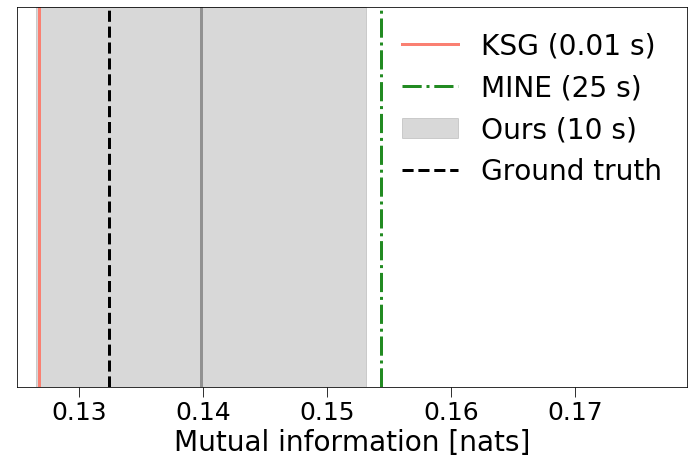

In [26]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

lw=3
label = '$N=200$ samples to fit, 20 bootstrap realisations'
ax.tick_params(axis='both', which='major', labelsize=25, size=10)
ax.axvline(knn_estimates, c='salmon', lw=lw, label='KSG (0.01 s)')
ax.axvline(mine_estimates, c='forestgreen', ls='-.', lw=lw, label='MINE (25 s)')

ax.axvline(all_MI_estimates[:, 0], color='grey', alpha=0.8, lw=3)
ax.axvspan(all_MI_estimates[:, 0] - all_MI_estimates[:, 1], all_MI_estimates[:, 0]+all_MI_estimates[:, 1], color='grey', alpha=0.3, label='Ours (10 s)')
ax.axvline(analytic, ls='--', c='black', lw=lw, label='Ground truth')

handles, labels = ax.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

#ax.set_title(label, fontsize=30)
ax.legend(handles, labels, fontsize=28, frameon=False)
        
ax.set_xlim((0.125, 0.179))
        
ax.axes.yaxis.set_ticks([])
ax.set_ylim((0.38, 0.62))
ax.set_xlabel('Mutual information [nats]', fontsize=28);

plt.savefig('../../figures/D3_comparison.pdf',  bbox_inches='tight');

### Actually look at residuals, only for ours

In [ ]:
N = 10000
random_states = 1000

n_inits = 10
n_folds = 3
init_type = 'random_sklearn'
MC_samples = 1e5
tol = 1e-5
reg_covar = 1e-15
components_range = 100
n_bootstrap = 50
patience = 1

initial_time = time.time()

all_MI_estimates = np.zeros((random_states, 2))

chi2, biases = [], []
bad_idx = []

for r_ in range(random_states):
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=r_+10000)
    X = gmm_true.sample(N)[0]


    best_val = -np.inf
    pat_counter = 0

    for n_components in range(1, components_range+1):
        current_seed, current_val, _ = MI_procedure_diffconvergence(X, n_components=n_components, n_folds=n_folds, 
                                                           init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, 
                                                           MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)

        # check if convergence has been reached based on val score
        if current_val > best_val:
            best_val = current_val
            best_seed = current_seed
            print(n_components, best_val)
        else:
            # if val score has not increased, then we should stop and calculate MI with the previous parameters
            pat_counter += 1
            if pat_counter >= patience:
                best_components = n_components-patience # note we retrieve the model based on patience!
                print(f'Convergence reached at {best_components} components') 
                w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=best_components, init_type=init_type)
                MI_estimates = np.zeros(n_bootstrap)

                # bootstrap available samples
                for i in range(n_bootstrap):
                    # we use i to change the seed so that the results will be fully reproducible
                    rng = np.random.default_rng(i)
                    X_bs = rng.choice(X, X.shape[0])
                    gmm = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                                tol=tol, max_iter=10000, 
                                random_state=best_seed, weights_init=w_init, 
                                means_init=m_init, precisions_init=p_init).fit(X_bs)


                    current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples) 
                    MI_estimates[i] = current_MI_estimate

                print(best_components, np.mean(MI_estimates), np.std(MI_estimates)) 
                break

    all_MI_estimates[r_, 0] = np.mean(MI_estimates)
    all_MI_estimates[r_, 1] = np.std(MI_estimates)
    
    chi2.append(    (np.mean(MI_estimates) - analytic)**2 / np.var(MI_estimates, ddof=1) )
    biases.append(  (np.mean(MI_estimates) - analytic) / np.sqrt(np.var(MI_estimates, ddof=1))  )
    
    if best_components == 3:
        bad_idx.append(r_)
        
    print(biases[-1])
    
    np.save('./D3_chi2_final.npy', chi2)
    np.save('./D3_biases_final.npy', biases)
    np.save('./D3_bad_idx.npy', bad_idx)

    
print(f'Total time for GMM: {time.time()-initial_time:.2f} s')

1 -2.4183637190011944
2 -2.372528010031036
3 -2.263501063228326
Convergence reached at 3 components
3 0.1333193901846762 0.003491096742023759
0.26440264448045225
1 -2.4100816835979706
2 -2.3682594654895595
3 -2.256718185532151
Convergence reached at 3 components
3 0.1252644044958628 0.024191522936310387
-0.291464651147589
1 -2.425628072991175
2 -2.369872485460414
3 -2.2709338415317064
4 -2.2704475189888704
Convergence reached at 4 components
4 0.13981299718397977 0.0036455590398135657
2.0165352121410987
1 -2.421958903661434
2 -2.3798580030186693
3 -2.274654403583853
Convergence reached at 3 components
3 0.12894234597669355 0.003915868455002384
-0.8708151271886181
1 -2.402253001180731
2 -2.3573123546297077
3 -2.2493441537792322
Convergence reached at 3 components
3 0.1316284687295747 0.0036956432271639346
-0.20317752050610705
1 -2.4118531637812683
2 -2.411824324553304
3 -2.2507806199090896
Convergence reached at 3 components
3 0.1328588486108842 0.004517342960149498
0.10341085834390827


2 -2.3710739194325314
3 -2.2539924344720856
Convergence reached at 3 components
3 0.12906316539101478 0.003263866251395687
-1.0081272071911709
1 -2.4051060552954047
2 -2.3675973809618593
3 -2.26299800383641
Convergence reached at 3 components
3 0.12597697032024122 0.004383335403660424
-1.4476577838460387
1 -2.4126466180508612
2 -2.3667812594203883
3 -2.263277798404831
Convergence reached at 3 components
3 0.13100441572190571 0.004671094331286758
-0.2930046985698476
1 -2.4210355406627975
2 -2.3784143043280177
3 -2.2701461698863312
Convergence reached at 3 components
3 0.13537094224963123 0.004115965767022771
0.7176901621284982
1 -2.418002145271173
2 -2.370152621816818
3 -2.2637606674845085
Convergence reached at 3 components
3 0.12579953837762736 0.002779038252776627
-2.3465737729774943
1 -2.41137455947554
2 -2.3684612899580713
3 -2.253542922599769
Convergence reached at 3 components
3 0.1419054783843483 0.014215828601285577
0.6628420432468884
1 -2.4175048033917728
2 -2.381052263309039


3 0.13200068944042495 0.0036771176090096263
-0.10399230157801412
1 -2.422113680700861
2 -2.3811466835766657
3 -2.277947491905847
Convergence reached at 3 components
3 0.12121605497277738 0.025854737647556778
-0.4277218165834862
1 -2.394371199874575
2 -2.3538633094307335
3 -2.248435028924377
4 -2.248198761750628
Convergence reached at 4 components
4 0.13234790919807432 0.0045750242332751
-0.008450643775526446
1 -2.4158739215650913
2 -2.3705625184424335
3 -2.2611735899931777
Convergence reached at 3 components
3 0.13230033655930726 0.0038988160168816153
-0.021995500518123618
1 -2.4104916817252113
2 -2.397942465486496
3 -2.2650877822393283
Convergence reached at 3 components
3 0.12914140860030734 0.0038801119289277354
-0.8280522835668159
1 -2.406201495614075
2 -2.3634257570270543
3 -2.2442179837896714
Convergence reached at 3 components
3 0.13734492495191394 0.0034448234343764476
1.4247845814945306
1 -2.4013329988824235
2 -2.360148698800099
3 -2.255197326382938
Convergence reached at 3 co

2 -2.3770370868417987
3 -2.268156055842036
4 -2.26812408427417
Convergence reached at 4 components
4 0.13703084853496927 0.003858980600916855
1.1913020563651078
1 -2.4202509341679046
2 -2.376944486352083
3 -2.2671312911682793
4 -2.2668406617024135
Convergence reached at 4 components
4 0.12930040761238348 0.004310536447564455
-0.7088525033751883
1 -2.422470269378975
2 -2.3827590330021367
3 -2.274977728619654
Convergence reached at 3 components
3 0.1322633819206415 0.003924616319028111
-0.031172381096679948
1 -2.4122789306658095
2 -2.3674123703887973
3 -2.263498883770459
Convergence reached at 3 components
3 0.12673009666640933 0.0041219498353260815
-1.3585833877141094
1 -2.4035992642004707
2 -2.3582022913093224
3 -2.2550910873553742
4 -2.255005734962319
Convergence reached at 4 components
4 0.12249263828446477 0.01677458876050634
-0.5839119212234892
1 -2.4118637249485015
2 -2.368381518981043
3 -2.2461229109117133
Convergence reached at 3 components
3 0.14357422332564285 0.00443779440551

3 -2.2488743146565255
Convergence reached at 3 components
3 0.12961156515904426 0.003646978265371063
-0.7533645928380165
1 -2.4143611600897903
2 -2.373651770536339
3 -2.263859928601526
Convergence reached at 3 components
3 0.13603718392588626 0.004163210892725206
0.8679679799620167
1 -2.4235420139004566
2 -2.379980842201222
3 -2.271403330165447
4 -2.2713570137411305
Convergence reached at 4 components
4 0.1361933421713575 0.013823262516531674
0.27259284993274335
1 -2.4128219809091966
2 -2.361163589763772
3 -2.262139363150379
Convergence reached at 3 components
3 0.12924562056166156 0.003613430960643152
-0.8606144682819428
1 -2.4132328010929167
2 -2.369051440032317
3 -2.2551555844025697
Convergence reached at 3 components
3 0.13377808895253093 0.02530755904637641
0.054416303887124505
1 -2.4152159030458313
2 -2.368994358612959
3 -2.2603454628138486
Convergence reached at 3 components
3 0.13839952262554295 0.0043557293076858595
1.3665058886448942
1 -2.4152637875396556
2 -2.370107193929128

2 -2.3775596723898698
3 -2.270324069205393
Convergence reached at 3 components
3 0.13523459931222828 0.004170677620616414
0.6759130705448669
1 -2.4333909900562443
2 -2.3883521698493184
3 -2.383391361207158
4 -2.277895554390385
Convergence reached at 4 components
4 0.13569894431984963 0.0035981635843828326
0.9112130521839017
1 -2.396883385594433
2 -2.355460024801167
3 -2.244210285051023
Convergence reached at 3 components
3 0.13016921714815644 0.0035165357913821134
-0.6243238010259927
1 -2.4266096416727616
2 -2.3791307651030498
3 -2.2709760181112766
4 -2.2709063812845667
Convergence reached at 4 components
4 0.13321999491051467 0.003928283100633591
0.2099285841355593
1 -2.4272903419863128
2 -2.387548006903341
3 -2.2768644346364764
4 -2.276438182451962
5 -2.276156855671981
Convergence reached at 5 components
5 0.1297959678933353 0.004329314727989461
-0.5924621016708528
1 -2.3998686131501468
2 -2.373707331823558
3 -2.255323385317858
Convergence reached at 3 components
3 0.1166487335886271

2 -2.3568438723150713
3 -2.2462793151142404
4 -2.2462492105220435
5 -2.246107361077821
Convergence reached at 5 components
5 0.14040064531895152 0.004045403682843576
1.9610255903591898
1 -2.4174175289096964
2 -2.377294993834209
3 -2.2580688617268048
Convergence reached at 3 components
3 0.13767717980464272 0.0036772695219529986
1.4241672543258466
1 -2.4108225636575806
2 -2.368755452317316
3 -2.2572423568426903
Convergence reached at 3 components
3 0.13658370926826457 0.003932000404802141
1.0566037148930623
1 -2.4085944937233337
2 -2.3695312755694946
3 -2.26181164406082
Convergence reached at 3 components
3 0.13195653313266426 0.004117238763152734
-0.10349276841970594
1 -2.416935440929633
2 -2.37404942025305
3 -2.2642434437184007
Convergence reached at 3 components
3 0.13483454964064348 0.004173062109743022
0.5806255654143901
1 -2.4138804754017187
2 -2.4138468457181848
3 -2.26417424221251
Convergence reached at 3 components
3 0.1296114766621363 0.004557586376493618
-0.6028611805627394
1

Convergence reached at 3 components
3 0.1241388249684964 0.03114154624512306
-0.26219766392720645
1 -2.4111935776941205
2 -2.3686388508328364
3 -2.257078893563215
Convergence reached at 3 components
3 0.13727144341228298 0.004467698181012928
1.08229967791226
1 -2.41233473564408
2 -2.412308667532692
3 -2.2528457520805385
Convergence reached at 3 components
3 0.12735419309832863 0.025301538090811152
-0.19691248044323725
1 -2.4223212181637455
2 -2.4222920538085
3 -2.27617606312351
Convergence reached at 3 components
3 0.12903170538014905 0.01217246428705098
-0.2728729460332529
1 -2.406245590139671
2 -2.364467272932329
3 -2.2526026135478943
Convergence reached at 3 components
3 0.13010047439219075 0.012740903918532892
-0.1776568493612326
1 -2.4154175029524527
2 -2.3667710360436423
3 -2.2562501646397872
Convergence reached at 3 components
3 0.11856624643799211 0.028529477758553596
-0.47956755770301884
1 -2.41035342325789
2 -2.364327811391378
3 -2.2535861499067056
Convergence reached at 3 co

2 -2.3785505174511106
3 -2.272428065667101
4 -2.272397429871425
Convergence reached at 4 components
4 0.10413550453778 0.044305902442755826
-0.6312368345192095
1 -2.4089478945905363
2 -2.365843474737908
3 -2.259924532328474
Convergence reached at 3 components
3 0.12622305674917905 0.0038952715479393966
-1.5665034916040648
1 -2.3998849215113345
2 -2.3572517096000607
3 -2.2491167555393443
4 -2.249087329906469
Convergence reached at 4 components
4 0.13263329088104558 0.0034068009140493473
0.07157786986969013
1 -2.4122150312382202
2 -2.3674848033895697
3 -2.25655994363476
Convergence reached at 3 components
3 0.13539632662066153 0.013143478300443451
0.2266612623994493
1 -2.4178458419028277
2 -2.375414499970319
3 -2.26874530691102
Convergence reached at 3 components
3 0.1258003239683666 0.003994352572916968
-1.6324148817315336
1 -2.4114396423378515
2 -2.3657191491606913
3 -2.2570300228454694
Convergence reached at 3 components
3 0.11977894060712309 0.029256228101345816
-0.42662047716058565


2 -2.3961502332780884
3 -2.262882354029216
Convergence reached at 3 components
3 0.13221174246074624 0.0038682308904378136
-0.0448422283064915
1 -2.4113523284741922
2 -2.3779506066847516
3 -2.2655268688507086
4 -2.265092750068122
Convergence reached at 4 components
4 0.1257145417334232 0.026702313524663582
-0.24737035076974162
1 -2.410349827738217
2 -2.4103143798258166
3 -2.2680261064376253
4 -2.267988159064563
Convergence reached at 4 components
4 0.12971502699278506 0.004566603963584383
-0.5792230565970189
1 -2.4028431070788923
2 -2.3652832651298112
3 -2.254160801257505
Convergence reached at 3 components
3 0.13375545059634827 0.005084303452581926
0.26645400045519657
1 -2.4040126616588955
2 -2.3607548523815383
3 -2.2601891756126116
Convergence reached at 3 components
3 0.12309082587597599 0.0039669964655242055
-2.319817254068116
1 -2.4200410564546466
2 -2.3744947370133747
3 -2.2622812890998696
4 -2.262025328379786
Convergence reached at 4 components
4 0.13750518325548666 0.0047007457

2 -2.3698802168275694
3 -2.2636840213143796
Convergence reached at 3 components
3 0.13709103530466465 0.004111926145753932
1.132509004895203
1 -2.401410495255757
2 -2.353681871646241
3 -2.2423343250198267
Convergence reached at 3 components
3 0.13485134788971187 0.026333414894031907
0.09264335730689682
1 -2.4165634350333502
2 -2.3741172495384775
3 -2.2553284526441306
Convergence reached at 3 components
3 0.13106657845976313 0.028991095144372897
-0.04508676230249843
1 -2.409636341438434
2 -2.3676298321466986
3 -2.2612036524238963
Convergence reached at 3 components
3 0.13053055036938832 0.004274210277044183
-0.42996372035983665
1 -2.418237618094976
2 -2.375510391798594
3 -2.269794021065207
Convergence reached at 3 components
3 0.12781405258302342 0.0037387679703213103
-1.2108135611509299
1 -2.4171196735356095
2 -2.3751950500213876
3 -2.2722116269154404
Convergence reached at 3 components
3 0.12783263190002872 0.01254247081603772
-0.35946333390984164
1 -2.4077417226088236
2 -2.3666705715

2 -2.3787860815398147
3 -2.2630481874613237
Convergence reached at 3 components
3 0.13598103170274223 0.004501367805818096
0.7904143889878247
1 -2.409920687577303
2 -2.3713978059926464
3 -2.254376933178351
4 -2.254009689754966
Convergence reached at 4 components
4 0.1308760068265114 0.024669711932128375
-0.060631875703387704
1 -2.411757177150825
2 -2.3700421152042908
3 -2.2563820222154454
Convergence reached at 3 components
3 0.13964978419892168 0.004346131009331279
1.654304839032553
1 -2.415268985296763
2 -2.369690731886534
3 -2.2616102089333943
Convergence reached at 3 components
3 0.13154210089837387 0.004013766476262795
-0.20837570478564008
1 -2.4211061570845867
2 -2.3772093501381666
3 -2.2697008918314254
4 -2.2696868956584733
Convergence reached at 4 components
4 0.13211254003044023 0.004093777399588211
-0.0663605911767331
1 -2.4203720130180817
2 -2.3778209457955715
3 -2.3199909408192014
4 -2.263389059742544
Convergence reached at 4 components
4 0.13150636556944925 0.0043110178455

4 -2.2702064238599893
Convergence reached at 4 components
4 0.1270192705471688 0.027903805640139723
-0.19043083595677035
1 -2.4171929783937904
2 -2.3715951589601185
3 -2.2602602686672344
Convergence reached at 3 components
3 0.14104357946774398 0.004282127760725874
2.0012510040082216
1 -2.4025011657123043
2 -2.360266962405653
3 -2.249119322406537
Convergence reached at 3 components
3 0.13239081829964025 0.003974407802868065
0.0009601287784523162
1 -2.4107495237803693
2 -2.367856731306196
3 -2.261980765737191
Convergence reached at 3 components
3 0.1366186020933032 0.004107030600688726
1.0199846985439736
1 -2.426642300929586
2 -2.3903125535798786
3 -2.286226037639346
Convergence reached at 3 components
3 0.12781008171187216 0.003908495176284742
-1.1592394816908107
1 -2.411093331854042
2 -2.364615478591585
3 -2.2614388304103925
4 -2.261391743086207
Convergence reached at 4 components
4 0.1313152562584336 0.004305178407769754
-0.2464325642974832
1 -2.4230335288467897
2 -2.3779229641715958

### D5

In [100]:
# three different models, chosen based on the number of components
n_components = 5

# fix random state for stability across runs
random_state = 13

if n_components == 1:
    weights = np.array([1.0])
    mu0, mu1, mu2 = [-1, 1], [0, 2], [-1.5, 2]
    means = np.array([mu0])
    C0, C1, C2 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]]
    covariances = np.array([C1])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 2:
    weights = np.array([0.96, 0.04])
    mu0, mu1 = [0, 0], [1, 1]
    means = np.array([mu0, mu1])
    C0, C1 = [[1, 0], [0, 1]], [[0.1, 0.], [0., 0.1]]
    covariances = np.array([C0, C1])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 3:
    weights = np.array([0.3, 0.45, 0.25])
    mu0, mu1, mu2 = [-1, 1], [0, 2], [-1.5, 2]
    means = np.array([mu0, mu1, mu2])
    C0, C1, C2 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]]
    covariances = np.array([C0, C1, C2])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 5:
    weights = np.array([0.2, 0.35, 0.15, 0.12, 0.18])
    mu0, mu1, mu2, mu3, mu4 = [-1, 1], [0, 2], [-1.5, 2], [2, 1], [-0.25, 0]
    means = np.array([mu0, mu1, mu2, mu3, mu4])
    C0, C1, C2, C3, C4 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]], [[0.5, -0.1], [-0.1, 0.9]], [[0.2, -0.05], [-0.05, 0.1]]
    covariances = np.array([C0, C1, C2, C3, C4])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 6:
    # this is for D5'
    n_components = 5
    weights = np.array([0.2, 0.35, 0.15, 0.12, 0.18])
    mu0, mu1, mu2, mu3, mu4 = [-1, 1], [0, 2], [-1.5, 2], [3, 1], [-0.25, 0]
    means = np.array([mu0, mu1, mu2, mu3, mu4])
    C0, C1, C2, C3, C4 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]], [[0.5, -0.1], [-0.1, 0.9]], [[0.2, -0.05], [-0.05, 0.1]]
    covariances = np.array([C0, C1, C2, C3, C4])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)

In [101]:
# let's do some numerical integration 
def logp(y, x, model):
    y = np.array(y)
    x = np.array(x)
    X = np.concatenate((y.reshape(1, 1), x.reshape(1, 1))).T
    return model.score_samples(X)

def p(y, x):
    return np.exp(logp(y, x))

def integrand(y, x, model=gmm_true):
    logp_ = logp(y, x, model)
    p_ = np.exp(logp_)
    return p_*logp_

def integrand_1d(x, model=gmm_true):
    x = np.array(x)
    w = gmm_true.weights_
    m = gmm_true.means_[:, :1]
    c = gmm_true.covariances_[:, :1, :1]
    gmm_marginal = my_GMM(n_components=n_components, weights_init=w, means_init=m, covariances_init=c, random_state=random_state)
    logp_1d = gmm_marginal.score_samples(x.reshape(-1, 1))
    p_ = np.exp(logp_1d)
    return p_*logp_1d


tol = 1e-12
limit = np.inf

twod_term = integrate.dblquad(integrand, -limit, limit, lambda x: -limit, lambda x: limit, args=[gmm_true], epsabs=tol, epsrel=tol)[0]

oned_term_x = integrate.quad(integrand_1d, -limit, limit, args=[gmm_true], epsabs=tol, epsrel=tol)[0]


def integrand_1d(y, model=gmm_true):
    y = np.array(y)
    w = gmm_true.weights_
    m = gmm_true.means_[:, 1:2]
    c = gmm_true.covariances_[:, 1:2, 1:2]
    gmm_marginal = my_GMM(n_components=n_components, weights_init=w, means_init=m, covariances_init=c, random_state=random_state)
    logp_1d = gmm_marginal.score_samples(y.reshape(-1, 1))
    p_ = np.exp(logp_1d)
    return p_*logp_1d


oned_term_y = integrate.quad(integrand_1d, -limit, limit, args=[gmm_true], epsabs=tol, epsrel=tol)[0]

analytic = twod_term - oned_term_x - oned_term_y
print(analytic)

0.16805279930870554


In [20]:
N = 1e3
knn_estimates = []
random_state = 17
n_neighbors = 3

initial_time = time.time()

gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
X_ = gmm_true.sample(N)[0]
knn_estimates.append(mutual_info_regression(X_[:, 0].reshape(-1, 1), X_[:, 1], n_neighbors=n_neighbors))
    
print(f'Total time for KSG: {time.time()-initial_time}')

Total time for KSG: 0.013418436050415039


In [21]:
knn_estimates

[array([0.18729477])]

In [22]:
# now we do this for many components, from 1 to 5
n_inits = 3
n_folds = 3
init_type = 'random_sklearn'
MC_samples = 1e4
tol = 1e-5
reg_covar = 1e-15
components_range = 100
n_bootstrap = 100
patience = 1

all_MI_estimates = np.zeros((1, 2))


initial_time = time.time()


best_val = -np.inf
pat_counter = 0

for n_components in range(1, components_range+1):
    current_seed, current_val, _ = MI_procedure_diffconvergence(X_, n_components=n_components, n_folds=n_folds, 
                                                       init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, 
                                                       MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)

    # check if convergence has been reached based on val score
    if current_val > best_val:
        best_val = current_val
        best_seed = current_seed
        print(n_components, best_val)
    else:
        # if val score has not increased, then we should stop and calculate MI with the previous parameters
        pat_counter += 1
        if pat_counter >= patience:
            best_components = n_components-patience # note we retrieve the model based on patience!
            print(f'Convergence reached at {best_components} components') 
            w_init, m_init, c_init, p_init = initialize_parameters(X_, best_seed, n_components=best_components, init_type=init_type)
            MI_estimates = np.zeros(n_bootstrap)

            # bootstrap available samples
            for i in range(n_bootstrap):
                # we use i to change the seed so that the results will be fully reproducible
                rng = np.random.default_rng(i)
                X_bs = rng.choice(X_, X_.shape[0])
                gmm = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                            tol=tol, max_iter=10000, 
                            random_state=best_seed, weights_init=w_init, 
                            means_init=m_init, precisions_init=p_init).fit(X_bs)


                current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples) # from nats to bits
                MI_estimates[i] = current_MI_estimate

            print(best_components, np.mean(MI_estimates), np.std(MI_estimates)) 
            break

all_MI_estimates[0, 0] = np.mean(MI_estimates)
all_MI_estimates[0, 1] = np.std(MI_estimates)


print(f'Total time for GMM: {time.time()-initial_time:.2f} s')

1 -2.968771353889314
2 -2.896678953419054
3 -2.82094608586168
4 -2.7883729486102884
5 -2.7532690196723912
Convergence reached at 5 components
5 0.1691333158138944 0.018874162428868066
Total time for GMM: 33.75 s


In [23]:
print(all_MI_estimates)

[[0.16913332 0.01887416]]


In [24]:
import torch
from torch.utils.data import TensorDataset, DataLoader
#import sys
#sys.path.insert(0, './mine-pytorch/mine')

from models.mine import MutualInformationEstimator
from pytorch_lightning import Trainer
import logging
logging.getLogger().setLevel(logging.ERROR)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_gpus = 1 if device=='cuda' else 0
print(device)
from sklearn.model_selection import train_test_split


cpu


In [73]:
# now take a single realisation and bootstrap it

mine_estimates = []

dim = 1
lr = 1e-3
epochs = 100
batch_size = 64
loss_type = ['mine']  # mine, mine_biased, fdiv
loss = loss_type[0]

initial_time = time.time()


# bootstrap available samples


N = X_.shape[0]
train_size = int(0.9 * N)
test_size = N - train_size

train_set, test_set = train_test_split(X_, test_size=0.1, random_state=42)

tensor_x = torch.Tensor(train_set[:, :1]) # transform to torch tensor
tensor_y = torch.Tensor(train_set[:, 1:]) # transform to torch tensor
my_dataset = TensorDataset(tensor_x,tensor_y)
train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

tensor_x = torch.Tensor(test_set[:, :1]) # transform to torch tensor
tensor_y = torch.Tensor(test_set[:, 1:]) # transform to torch tensor
my_dataset = TensorDataset(tensor_x,tensor_y)
test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

#train_loader = torch.utils.data.DataLoader(
#        MultivariateNormalDataset(N, dim, rho), batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(
#        MultivariateNormalDataset(N, dim, rho), batch_size=batch_size, shuffle=True)

kwargs = {
    'lr': lr,
    'batch_size': batch_size,
    'train_loader': train_loader,
    'test_loader': test_loader,
    'alpha': 1.0
}

model = MutualInformationEstimator(
    dim, dim, loss=loss, **kwargs).to(device)


trainer = Trainer(max_epochs=epochs, early_stop_callback=False, gpus=num_gpus)
trainer.fit(model)
trainer.test()

mine_estimates.append(model.avg_test_mi)
print(mine_estimates[-1])
print()
#print("True_mi {}".format(true_mi))
#print("MINE {}".format(model.avg_test_mi*np.log2(np.exp(1))))

print(f'Total time for MINE: {time.time()-initial_time:.2f} s')

Testing: 100%|██████████| 15/15 [00:00<00:00, 393.46batch/s]
0.15463744

Total time for MINE: 25.94 s


In [72]:
mine_estimates

[array(0.13414949, dtype=float32)]

In [74]:
#np.save('./D5_knn.npy', knn_estimates)
#np.save('./D5_mine.npy', mine_estimates)
#np.save('./D5_ours.npy', all_MI_estimates)
#np.save('./D5_analytic.npy', analytic)

In [27]:
knn_estimates = np.load('./D5_knn.npy')
mine_estimates = np.load('./D5_mine.npy')
all_MI_estimates = np.load('./D5_ours.npy')
analytic = np.load('./D5_analytic.npy')

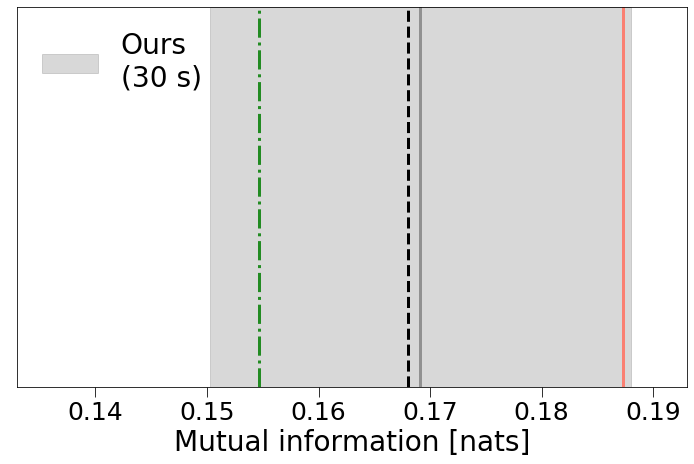

In [29]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

lw=3
label = '$N=200$ samples to fit, 20 bootstrap realisations'
ax.tick_params(axis='both', which='major', labelsize=25, size=10)
#ax.axvline(knn_estimates, c='salmon', lw=lw, label='KSG (0.01 s)')
ax.axvline(knn_estimates, c='salmon', lw=lw)
#ax.axvline(mine_estimates, c='forestgreen', ls='-.', lw=lw, label='MINE (25 s)')
ax.axvline(mine_estimates, c='forestgreen', ls='-.', lw=lw)

ax.axvline(all_MI_estimates[:, 0], color='grey', alpha=0.8, lw=3)
ax.axvspan(all_MI_estimates[:, 0] - all_MI_estimates[:, 1], all_MI_estimates[:, 0]+all_MI_estimates[:, 1], color='grey', alpha=0.3, label='Ours\n(30 s)')
#ax.errorbar( np.mean(MI_estimates), 0.5, 0, np.std(MI_estimates), fmt='.', markersize=20, color='grey', capsize=10, elinewidth=2, label='Ours (30 s)')
#ax.axvline(analytic, ls='--', c='black', lw=lw, label='Ground truth')
ax.axvline(analytic, ls='--', c='black', lw=lw)


#handles, labels = ax.get_legend_handles_labels()
#i1, i2 = -1, -2
#handles[i1], handles[i2] = handles[i2], handles[i1] 
#labels[i1], labels[i2] = labels[i2], labels[i1] 

#ax.set_title(label, fontsize=30)
ax.legend(fontsize=28, frameon=False, loc='upper left')
        
ax.set_xlim((0.133, 0.193))
        
ax.axes.yaxis.set_ticks([])
ax.set_ylim((0.38, 0.62))
ax.set_xlabel('Mutual information [nats]', fontsize=28);

plt.savefig('../../figures/D5_comparison.pdf',  bbox_inches='tight');

### Residuals

In [ ]:
N = 10000
random_states = 1000

n_inits = 10
n_folds = 3
init_type = 'random_sklearn'
MC_samples = 1e5
tol = 1e-5
reg_covar = 1e-15
components_range = 100
n_bootstrap = 50
patience = 1

initial_time = time.time()

all_MI_estimates = np.zeros((random_states, 2))

chi2, biases = [], []
bad_idx = []

for r_ in range(random_states):
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=r_+30000)
    X = gmm_true.sample(N)[0]


    best_val = -np.inf
    pat_counter = 0

    for n_components in range(1, components_range+1):
        current_seed, current_val, _ = MI_procedure_diffconvergence(X, n_components=n_components, n_folds=n_folds, 
                                                           init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, 
                                                           MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)

        # check if convergence has been reached based on val score
        if current_val > best_val:
            best_val = current_val
            best_seed = current_seed
            print(n_components, best_val)
        else:
            # if val score has not increased, then we should stop and calculate MI with the previous parameters
            pat_counter += 1
            if pat_counter >= patience:
                best_components = n_components-patience # note we retrieve the model based on patience!
                print(f'Convergence reached at {best_components} components') 
                w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=best_components, init_type=init_type)
                MI_estimates = np.zeros(n_bootstrap)

                # bootstrap available samples
                for i in range(n_bootstrap):
                    # we use i to change the seed so that the results will be fully reproducible
                    rng = np.random.default_rng(i)
                    X_bs = rng.choice(X, X.shape[0])
                    gmm = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                                tol=tol, max_iter=10000, 
                                random_state=best_seed, weights_init=w_init, 
                                means_init=m_init, precisions_init=p_init).fit(X_bs)


                    current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples) 
                    MI_estimates[i] = current_MI_estimate

                print(best_components, np.mean(MI_estimates), np.std(MI_estimates)) 
                break

    all_MI_estimates[r_, 0] = np.mean(MI_estimates)
    all_MI_estimates[r_, 1] = np.std(MI_estimates)
    
    chi2.append(    (np.mean(MI_estimates) - analytic)**2 / np.var(MI_estimates, ddof=1) )
    biases.append(  (np.mean(MI_estimates) - analytic) / np.sqrt(np.var(MI_estimates, ddof=1))  )
    
    if best_components == 1:
        bad_idx.append(r_)
        
    print(biases[-1])
    
    np.save('./D5_chi2_final_bis.npy', chi2)
    np.save('./D5_biases_final_bis.npy', biases)
    np.save('./D5_bad_idx_bis.npy', bad_idx)

    
print(f'Total time for GMM: {time.time()-initial_time:.2f} s')

1 -2.984313813414999
2 -2.910401756935329
3 -2.8228732184186156
4 -2.7829595871224737
5 -2.7339239176869783
6 -2.733288143179257
Convergence reached at 6 components
6 0.17215592447399009 0.004593490704711919
0.8842701424507555
1 -2.9982018924758713
2 -2.932306548097193
3 -2.830011674163533
4 -2.7855385032594575
5 -2.755406014471602
6 -2.755300986819029
Convergence reached at 6 components
6 0.16302415490368344 0.005197354140855085
-0.9578150435087863
1 -2.9728022848912308
2 -2.8956901949613467
3 -2.800896752050857
4 -2.7558911380920286
5 -2.7170595460160705
Convergence reached at 5 components
5 0.17049746865377682 0.013475016705497228
0.1795989743994158
1 -2.991101331619261
2 -2.919866785696987
3 -2.8218477647120097
4 -2.772049928708205
5 -2.727084924477372
Convergence reached at 5 components
5 0.1795364766023934 0.006267183792494357
1.813934439878609
1 -2.984271407733816
2 -2.9052152171482333
3 -2.8091452318670327
4 -2.77437087480642
5 -2.7293982316328247
Convergence reached at 5 compo

4 -2.7479957873026417
5 -2.711234511361024
Convergence reached at 5 components
5 0.17213469259675057 0.004758098402132109
0.849261165315198
1 -2.9663243195866578
2 -2.895617975982456
3 -2.7935601623397566
4 -2.739386723323884
5 -2.7095300095228736
Convergence reached at 5 components
5 0.17184175838732446 0.008427999167013943
0.4450496549717421
1 -2.978056962778098
2 -2.9065057639295375
3 -2.801240807105607
4 -2.753737692501039
5 -2.724696942524215
Convergence reached at 5 components
5 0.17061864346814917 0.004384042759645663
0.579386713522837
1 -2.999537958367602
2 -2.93104667501893
3 -2.818579326512183
4 -2.7674106657287343
5 -2.7391747930467383
Convergence reached at 5 components
5 0.17374694084217993 0.008013253230811477
0.7034486949973947
1 -2.990739751696042
2 -2.921611559829017
3 -2.8157737465487664
4 -2.766704247555152
5 -2.735807050347001
Convergence reached at 5 components
5 0.1661439541113793 0.008551881817572365
-0.22096427159315826
1 -2.9778006817589406
2 -2.914461150489283

3 -2.8155189468424937
4 -2.76966174049619
5 -2.7281097252948463
Convergence reached at 5 components
5 0.16079941982351953 0.029804590592691447
-0.24091857012298457
1 -2.9741560014834048
2 -2.900572917820559
3 -2.8072848341308276
4 -2.7565585707542763
5 -2.72789424896525
6 -2.7277539915240623
Convergence reached at 6 components
6 0.16781547313361686 0.005730417173811689
-0.04099892202181517
1 -2.99720900168912
2 -2.918152462540372
3 -2.8338099708950906
4 -2.7893936299729654
5 -2.7504359642874547
6 -2.7503027031300156
7 -2.7500342773068263
Convergence reached at 7 components
7 0.1670760455838599 0.004508876276608402
-0.21445184920219615
1 -2.986442068455459
2 -2.9084313128712864
3 -2.818245713539318
4 -2.787706555643814
5 -2.737767127932994
6 -2.7376863032981333
Convergence reached at 6 components
6 0.17275853760099988 0.005071249820603736
0.9185986501458049
1 -2.985704480610993
2 -2.985677623138964
3 -2.8161291705018523
4 -2.7655967496787475
5 -2.7324998326146894
Convergence reached at 

Convergence reached at 5 components
5 0.15934092990352858 0.00881865340811882
-0.9779623154888067
1 -2.9953602357604026
2 -2.925777264761365
3 -2.822731126868798
4 -2.7643989128295776
5 -2.7291791872302156
Convergence reached at 5 components
5 0.1794533609207148 0.004697856028521709
2.4023682562304685
1 -2.998336932352048
2 -2.938741040518257
3 -2.829686488372816
4 -2.7861072770238295
5 -2.7503139198346904
Convergence reached at 5 components
5 0.17165645246152406 0.0050999288228670255
0.6995067456564338
1 -2.989703896833515
2 -2.9232574779250142
3 -2.823680680495944
4 -2.7755468430469747
5 -2.743097448539514
Convergence reached at 5 components
5 0.167592758569122 0.006556917866948452
-0.06945597099970546
1 -2.9871932531252914
2 -2.9220919850309595
3 -2.8176327581033878
4 -2.7668202162391853
5 -2.73850533884476
Convergence reached at 5 components
5 0.1661375265499755 0.01365706305155206
-0.13883096904296427
1 -2.973020593348599
2 -2.8935550284071034
3 -2.7934850416780175
4 -2.7438581154

4 -2.7583926114398944
5 -2.717991580209013
Convergence reached at 5 components
5 0.1667649700251111 0.004658326952659649
-0.2736789324090815
1 -2.976375365870014
2 -2.8955543341040904
3 -2.8055241965245252
4 -2.7615264667180384
5 -2.7202592964838472
Convergence reached at 5 components
5 0.17167890814774853 0.009853013312351663
0.36432150199887714
1 -3.001777124591429
2 -2.930745973548103
3 -2.8408154363594718
4 -2.803783249174144
5 -2.76237027854507
6 -2.7622711411159897
Convergence reached at 6 components
6 0.1617332176844583 0.004436248739813391
-1.4102154761811472
1 -2.977997391751439
2 -2.9002868632637226
3 -2.80547359780239
4 -2.7677576060430944
5 -2.7285651473490393
6 -2.728501829213343
Convergence reached at 6 components
6 0.17439124760325384 0.003922182834559349
1.5998090717488263
1 -2.9941462664119207
2 -2.925368134848272
3 -2.8210100932604707
4 -2.7788569487348855
5 -2.7409951179242107
Convergence reached at 5 components
5 0.17483020940116412 0.004221516993045351
1.5893087012

Convergence reached at 5 components
5 0.17091681933887945 0.008622696835894223
0.328810722754823
1 -3.005831981706445
2 -2.942951901627792
3 -2.832351318893912
4 -2.787849470672993
5 -2.7568578874163467
6 -2.7562522930319946
Convergence reached at 6 components
6 0.15511327992896612 0.045975930397386365
-0.2786125380710094
1 -2.9880361637312873
2 -2.906688947229114
3 -2.8166397904295493
4 -2.767089569772015
5 -2.7376263511326315
Convergence reached at 5 components
5 0.1684802196039238 0.004498369309956216
0.09406175342147079
1 -2.971194372288096
2 -2.9034716190590353
3 -2.805174646106041
4 -2.753178483518727
5 -2.7237683993525863
Convergence reached at 5 components
5 0.1633981880226466 0.004955559769852144
-0.9298303924928889
1 -2.991025721118896
2 -2.9200804819605337
3 -2.8240179156393403
4 -2.770241323947611
5 -2.739088955138385
6 -2.738956683233957
Convergence reached at 6 components
6 0.17273374049495377 0.0053082657013625795
0.872958442150826
1 -2.9764166542636334
2 -2.899448502550

6 0.17056420035296255 0.004993052788220191
0.4979238749503713
1 -2.991811434732069
2 -2.9135074049702534
3 -2.8135219838153276
4 -2.766996500012084
5 -2.7313665691266205
Convergence reached at 5 components
5 0.15543019486209908 0.021577810671508765
-0.5791014237186984
1 -2.9796740091159197
2 -2.903535704608604
3 -2.8148886477580857
4 -2.7652662500214547
5 -2.731960358727537
6 -2.7319199950331368
7 -2.7317554113219917
8 -2.7311979444290237
Convergence reached at 8 components
8 0.16886722630802622 0.004505669516949076
0.17893935464388644
1 -2.990730343354201
2 -2.9046232235261513
3 -2.815764296081877
4 -2.780689413180523
5 -2.732955869590494
Convergence reached at 5 components
5 0.17093840751973383 0.0044731624500965765
0.6386100257437075
1 -2.9701703651725975
2 -2.8871297203495487
3 -2.799940110531256
4 -2.7518179672069785
5 -2.724554863057373
6 -2.7244849447709556
Convergence reached at 6 components
6 0.16266976405743733 0.005594045273799811
-0.952608132492543
1 -2.9864687016887284
2 -

6 0.16741854739354978 0.005267115315732543
-0.11920706584620212
1 -2.966204419101434
2 -2.8882869750985747
3 -2.8056401242177778
4 -2.759439365591671
5 -2.721144305258075
Convergence reached at 5 components
5 0.16731123474050397 0.004598665400430649
-0.1596357649198522
1 -3.0029846703594427
2 -2.936015426102968
3 -2.8240343768486533
4 -2.76991663209035
5 -2.7394724080752404
6 -2.739350282477906
Convergence reached at 6 components
6 0.1762826900682169 0.005442675291114214
1.4969065311623821
1 -2.9759752466138445
2 -2.8953490940492927
3 -2.8106115237914273
4 -2.767309057985775
5 -2.7297701964333627
Convergence reached at 5 components
5 0.16810769013071078 0.005889374826689626
0.009226640016947214
1 -2.9887369647323747
2 -2.9167510357660156
3 -2.8265802846461034
4 -2.7799579553451648
5 -2.746949856142338
6 -2.746782139075362
7 -2.746728632030644
Convergence reached at 7 components
7 0.16314331220255907 0.004686801464749442
-1.036985311074095
1 -2.979239066369584
2 -2.909012259689199
3 -2.

5 0.16877060963171936 0.010075100047892867
0.07052991657000059
1 -2.973549221991099
2 -2.896276217563223
3 -2.8105684369789343
4 -2.7548893885996653
5 -2.7235664636084382
Convergence reached at 5 components
5 0.1698374128309344 0.006768749604722847
0.26100496485771113
1 -2.9782900885654056
2 -2.9170356347863198
3 -2.813222771542955
4 -2.7725164208781963
5 -2.7314988888673164
Convergence reached at 5 components
5 0.15966170656048584 0.040399521189338726
-0.2056152591124297
1 -2.9870183007181565
2 -2.912028799154738
3 -2.8189978308490757
4 -2.7661607813916045
5 -2.7354067698936224
6 -2.7352631360560906
Convergence reached at 6 components
6 0.164233014983916 0.004136853159076374
-0.9140748807880187
1 -2.984696159045153
2 -2.9022448911046577
3 -2.808221732123293
4 -2.7576786961694304
5 -2.723949046584058
6 -2.7237166463312206
Convergence reached at 6 components
6 0.174125930827039 0.005058125240085779
1.1886011488734771
1 -3.0010969767230313
2 -2.9303937569472525
3 -2.825108008335475
4 -2.

2 -2.8920625987738844
3 -2.796280307838638
4 -2.753203960055822
5 -2.719728344120753
6 -2.719548544577345
Convergence reached at 6 components
6 0.16339103240351766 0.005620371754739707
-0.8211047220257859
1 -2.986458139268254
2 -2.9063709409611023
3 -2.811593818777348
4 -2.7661505135712865
5 -2.7350750323886
Convergence reached at 5 components
5 0.16676348349052794 0.0074942932945474185
-0.17031059383582897
1 -2.981095637797678
2 -2.9069701936877195
3 -2.814207177542493
4 -2.77829928720888
5 -2.7309605559951646
Convergence reached at 5 components
5 0.17100581332564438 0.005006242887717682
0.5839378544766667
1 -2.994541858988633
2 -2.9159523158962912
3 -2.8199365211559413
4 -2.766222681249074
5 -2.734423686977889
Convergence reached at 5 components
5 0.1730319490070638 0.004781746369873461
1.0308172666387916
1 -2.9826822351692814
2 -2.9201821225298468
3 -2.8081137777659397
4 -2.759474906929121
5 -2.7283995939737196
Convergence reached at 5 components
5 0.17110691437059167 0.005393281987

5 0.1716055902451531 0.007942499624413027
0.4428182253619136
1 -2.9802919834032675
2 -2.9177326422251113
3 -2.820220551652762
4 -2.7754271170577076
5 -2.7407772595474604
Convergence reached at 5 components
5 0.16537204443075182 0.008582188746132511
-0.30922320780417484
1 -2.989934912682505
2 -2.916157007801647
3 -2.8153670674786166
4 -2.767912138831153
5 -2.738175353780408
Convergence reached at 5 components
5 0.1654719759716171 0.006236321894629024
-0.40967814024801663
1 -2.9578212944981352
2 -2.8969757769787403
3 -2.7918553879586647
4 -2.7472664342618613
5 -2.7194267609528153
Convergence reached at 5 components
5 0.16110824380803684 0.004163441474897491
-1.6512203289126588
1 -2.977972246333041
2 -2.8973111369023594
3 -2.8111344279277266
4 -2.7643274142326946
5 -2.7320032734149255
Convergence reached at 5 components
5 0.15724398650712768 0.013201391454056105
-0.8105341620418903
1 -2.9894347930507177
2 -2.9265194314355374
3 -2.8237537098236545
4 -2.7807125066346647
5 -2.742240572472217

Convergence reached at 5 components
5 0.16083931453636577 0.012541582962846437
-0.5693847115683052
1 -2.9706072858169876
2 -2.8931215285082303
3 -2.8019438119154465
4 -2.7541609713448616
5 -2.72317642349493
6 -2.723112469082246
Convergence reached at 6 components
6 0.17070586471785712 0.004073547206656544
0.6447453841084227
1 -2.985822653470103
2 -2.9043827278994105
3 -2.810054334800458
4 -2.7638658884431035
5 -2.7337892786787603
6 -2.733732894387881
Convergence reached at 6 components
6 0.16938058894917077 0.004810189118669545
0.2732625786303102
1 -2.9871812535248528
2 -2.916763042234647
3 -2.812142778286647
4 -2.763743960710443
5 -2.735195792034182
Convergence reached at 5 components
5 0.16467074945036966 0.01638458540568234
-0.20434197521014336
1 -2.9881167746034976
2 -2.9267961894813026
3 -2.8230949357739177
4 -2.7872748830637444
5 -2.7469583078452757
6 -2.74686951206426
Convergence reached at 6 components
6 0.1609938556095004 0.004831371455217966
-1.4463797299757677
1 -2.989418836

2 -2.919427148922823
3 -2.827577408868363
4 -2.7706895576077293
5 -2.737977870191892
6 -2.7379299292208135
Convergence reached at 6 components
6 0.17188793987510234 0.004769673612485583
0.7959864280619877
1 -2.9964721457952064
2 -2.921431734284796
3 -2.825010363000295
4 -2.78923518121248
5 -2.739440995000199
6 -2.7394313480394685
Convergence reached at 6 components
6 0.17655298323299667 0.0051271136251034195
1.6412261141782407
1 -2.985327580427399
2 -2.9101251624450453
3 -2.8152463768952387
4 -2.7665367494942745
5 -2.735138636440373
Convergence reached at 5 components
5 0.1663510869948972 0.004912257204250239
-0.3429399506919052
1 -2.9871262589501026
2 -2.928803207610795
3 -2.821487525041091
4 -2.768621741120113
5 -2.7425506880283463
6 -2.742428802592362
Convergence reached at 6 components
6 0.16107553313639603 0.005251397177330952
-1.3152958881559162
1 -2.98234800721247
2 -2.9012805474252725
3 -2.8138956375893915
4 -2.765550660511145
5 -2.734229426674696
6 -2.7341611652525466
7 -2.734

2 -2.922948797766482
3 -2.809066613601902
4 -2.7577626718145396
5 -2.7279500163490114
6 -2.7278262873598376
7 -2.727821153197343
8 -2.7277267568749797
Convergence reached at 8 components
8 0.1756371456679884 0.005018448177520516
1.4961038895957195
1 -2.9791458587926307
2 -2.9097306617562615
3 -2.80888881726956
4 -2.762986970793017
5 -2.7266270158206694
6 -2.726442115922167
Convergence reached at 6 components
6 0.1700489787568366 0.006003153048363346
0.329179819007436
1 -2.9749859241765972
2 -2.9097176780504608
3 -2.799613365173071
4 -2.7528271144358274
5 -2.726105491619308
6 -2.726068971181873
7 -2.725816423193479
8 -2.7256682742746867
9 -2.7254278083717343
Convergence reached at 9 components
9 0.16196727130660482 0.004386946872814546
-1.3732478507257109
1 -2.973121332910877
2 -2.8954815298720398
3 -2.7955593920257296
4 -2.7495853818211753
5 -2.7158823680457247
6 -2.715849665289468
Convergence reached at 6 components
6 0.17436737617209744 0.0042849491357214746
1.4588532957105464
1 -2.9

2 -2.8901074121368566
3 -2.7946009520849118
4 -2.74271502761419
5 -2.71284243036947
Convergence reached at 5 components
5 0.17513072778158956 0.008735234037445054
0.802129820204667
1 -2.9943464654494147
2 -2.910965992842954
3 -2.8121133880444407
4 -2.759436733310729
5 -2.7247494570613155
Convergence reached at 5 components
5 0.1855669466820714 0.004339630705607056
3.9952987939201217
1 -2.9726524303460202
2 -2.91040979854939
3 -2.808796244087084
4 -2.7653892554643122
5 -2.7319769305481407
Convergence reached at 5 components
5 0.15623935419086243 0.009183124662384027
-1.2735005178255634
1 -2.975258172899318
2 -2.8980469104420465
3 -2.798225797677409
4 -2.7457787299890484
5 -2.713711319913422
Convergence reached at 5 components
5 0.1721727549855127 0.005401216745616538
0.7551165280437478
1 -2.989889816043146
2 -2.909587111999946
3 -2.815957987487835
4 -2.7790544666176302
5 -2.729964483384759
Convergence reached at 5 components
5 0.1777850426957775 0.004825436707558392
1.996592225140596
1 

5 0.17518768283606995 0.003565653019529083
1.9808922227038883
1 -2.9646482223326203
2 -2.885174633765945
3 -2.802365115502623
4 -2.753586162289322
5 -2.716545292865804
6 -2.7162384129376544
7 -2.7161140953132406
8 -2.715952351115853
Convergence reached at 8 components
8 0.16723497923371858 0.005268788617857563
-0.15365971722518687
1 -2.987695816368078
2 -2.9118396046136645
3 -2.816637895144192
4 -2.7691855407520474
5 -2.7349342729235655
6 -2.7346026077272536
Convergence reached at 6 components
6 0.17387856849261626 0.00544424088091622
1.0593244090310492
1 -2.969251319765704
2 -2.899240201081341
3 -2.8079494336787363
4 -2.7568587211521955
5 -2.7267996314661835
Convergence reached at 5 components
5 0.16270965468933205 0.005804712881045779
-0.9112325482589978
1 -2.994752292391528
2 -2.926770216624792
3 -2.8196856594831687
4 -2.772225716361676
5 -2.7429724109007054
Convergence reached at 5 components
5 0.1687737226122062 0.004767968227022661
0.1496817145769154
1 -2.967511591410362
2 -2.895

5 0.17022959603689775 0.004775269760208759
0.45126640526858025
1 -2.977356116325059
2 -2.8953483096459163
3 -2.803862551134287
4 -2.758966629832475
5 -2.725249091654008
Convergence reached at 5 components
5 0.1692428135627695 0.005455768201441299
0.21592816350756336
1 -2.988514460634493
2 -2.9097751838077532
3 -2.819304533396844
4 -2.7668000366621577
5 -2.732284059795266
Convergence reached at 5 components
5 0.1714198507751132 0.005379658633623228
0.6195952422461476
1 -2.9723654623993045
2 -2.906950298745397
3 -2.8071708878892387
4 -2.756059268490437
5 -2.728131546697558
Convergence reached at 5 components
5 0.16407913857930573 0.007005586964264776
-0.5615123253934853
1 -2.9854754341414265
2 -2.905775922201997
3 -2.8105242778832946
4 -2.7559882302878935
5 -2.7245989511275197
6 -2.7244602167559457
Convergence reached at 6 components
6 0.17382224054196505 0.00506050476596643
1.1286335438283817
1 -2.9688349265215392
2 -2.8891843431174986
3 -2.79749320105873
4 -2.746107094683927
5 -2.71677

Convergence reached at 5 components
5 0.17048841520831953 0.005749772587531882
0.4193447114420493
1 -2.97545838365806
2 -2.9039523883106284
3 -2.8005588926736746
4 -2.7590083831461456
5 -2.7194214018954654
6 -2.719350078755671
Convergence reached at 6 components
6 0.16924932383176525 0.0050080374500052075
0.2365195663133266
1 -2.981480155973434
2 -2.913938092093669
3 -2.817405124453987
4 -2.7790034585942904
5 -2.7378416478529264
Convergence reached at 5 components
5 0.16751136102564768 0.005789492188981875
-0.09258092707715682
1 -2.97689671635486
2 -2.909567526998949
3 -2.811467381545146
4 -2.7660633693602406
5 -2.730332789114581
Convergence reached at 5 components
5 0.16089908532564604 0.005515248348366928
-1.2840429094047043
1 -2.9816840689879083
2 -2.9203135968323313
3 -2.812044905132367
4 -2.770663046748424
5 -2.727994209777712
Convergence reached at 5 components
5 0.16985814242213693 0.005084487579706173
0.35150021964049305
1 -2.982953916878698
2 -2.908597628471663
3 -2.8174602394

2 -2.9051784902817377
3 -2.809563291195829
4 -2.759411008818034
5 -2.726555792275678
Convergence reached at 5 components
5 0.16526777066242818 0.004207254426449002
-0.6553056741427227
1 -2.994739565637618
2 -2.9256311346053345
3 -2.8220800045428103
4 -2.7716942265202413
5 -2.7386966788330747
Convergence reached at 5 components
5 0.168089575139006 0.00687703314629814
0.005293883831940346
1 -2.986487581384386
2 -2.9232295938963744
3 -2.823311683477117
4 -2.7799639211677873
5 -2.7503520887046684
6 -2.750329989617398
Convergence reached at 6 components
6 0.1535519899448629 0.004608914448653905
-3.1146312320042524
1 -2.9801616834420632
2 -2.9073801988648955
3 -2.8040291374775115
4 -2.7607909021293757
5 -2.7242343943172203
Convergence reached at 5 components
5 0.17226097094884962 0.006025587799282688
0.6913644814694831
1 -2.975354251165747
2 -2.893153204023889
3 -2.8011147122810827
4 -2.7524428221155257
5 -2.723603172064795
6 -2.7234671974786893
Convergence reached at 6 components
6 0.166877

5 -2.7210775073162132
Convergence reached at 5 components
5 0.16545002557471633 0.005603340874645158
-0.45983540850356824
1 -2.9885361943820286
2 -2.913284176302939
3 -2.827623327551059
4 -2.7751161141646215
5 -2.7467641426142198
Convergence reached at 5 components
5 0.16907733360386892 0.006086754915754053
0.1666302029198505
1 -2.9858505807780547
2 -2.9181219561416807
3 -2.810627727139485
4 -2.7650438251825826
5 -2.7337469682081355
6 -2.7334152338913564
Convergence reached at 6 components
6 0.16945506836687257 0.004793475446207276
0.28959688219693325
1 -2.9723757409932143
2 -2.911281316939989
3 -2.8090779222106304
4 -2.7630640052749853
5 -2.7308079452150054
Convergence reached at 5 components
5 0.16527343362497107 0.004261499417863294
-0.6456487216163265
1 -2.984194443966897
2 -2.9183522551227674
3 -2.8177057457339525
4 -2.767373396609543
5 -2.735965651445582
Convergence reached at 5 components
5 0.16751727460717883 0.00551539289314573
-0.09612051532688581
1 -2.986442156479581
2 -2.91

2 -2.905976370788961
3 -2.811459011853151
4 -2.767299384566819
5 -2.726350386731505
Convergence reached at 5 components
5 0.1713607542907301 0.004226369320952489
0.7748277802591907
1 -2.992509996871013
2 -2.91256314020054
3 -2.818363587973629
4 -2.77001930416432
5 -2.7416174774303825
6 -2.7415211414255887
Convergence reached at 6 components
6 0.17182410997612346 0.00489771132594444
0.7622758544123481
1 -2.988561862671968
2 -2.90945989107094
3 -2.813979660500348
4 -2.7758700708337725
5 -2.7367427687173724
Convergence reached at 5 components
5 0.1661755351796406 0.004567643493147275
-0.4068611477284114
1 -2.989198243767763
2 -2.9134701332602373
3 -2.820408807567802
4 -2.772739883103196
5 -2.739913774674767
Convergence reached at 5 components
5 0.17032199177530327 0.005557394910855706
0.40421563868713306
1 -2.987222649288833
2 -2.9073936713146487
3 -2.8186997217079095
4 -2.7676376779491183
5 -2.7351817736920485
Convergence reached at 5 components
5 0.16810265064108357 0.00436056970473095


In [77]:
analytic

0.16805279930870554

In [81]:
gmm_true.estimate_MI_MC(MC_samples=MC_samples) 

0.1727690506903256

### D1

In [96]:
# three different models, chosen based on the number of components
n_components = 1

# fix random state for stability across runs
random_state = 13

if n_components == 1:
    weights = np.array([1.0])
    mu0, mu1, mu2 = [-1, 1], [0, 2], [-1.5, 2]
    means = np.array([mu0])
    C0, C1, C2 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]]
    covariances = np.array([C1])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 2:
    weights = np.array([0.96, 0.04])
    mu0, mu1 = [0, 0], [1, 1]
    means = np.array([mu0, mu1])
    C0, C1 = [[1, 0], [0, 1]], [[0.1, 0.], [0., 0.1]]
    covariances = np.array([C0, C1])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 3:
    weights = np.array([0.3, 0.45, 0.25])
    mu0, mu1, mu2 = [-1, 1], [0, 2], [-1.5, 2]
    means = np.array([mu0, mu1, mu2])
    C0, C1, C2 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]]
    covariances = np.array([C0, C1, C2])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 5:
    weights = np.array([0.2, 0.35, 0.15, 0.12, 0.18])
    mu0, mu1, mu2, mu3, mu4 = [-1, 1], [0, 2], [-1.5, 2], [2, 1], [-0.25, 0]
    means = np.array([mu0, mu1, mu2, mu3, mu4])
    C0, C1, C2, C3, C4 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]], [[0.5, -0.1], [-0.1, 0.9]], [[0.2, -0.05], [-0.05, 0.1]]
    covariances = np.array([C0, C1, C2, C3, C4])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
elif n_components == 6:
    # this is for D5'
    n_components = 5
    weights = np.array([0.2, 0.35, 0.15, 0.12, 0.18])
    mu0, mu1, mu2, mu3, mu4 = [-1, 1], [0, 2], [-1.5, 2], [3, 1], [-0.25, 0]
    means = np.array([mu0, mu1, mu2, mu3, mu4])
    C0, C1, C2, C3, C4 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]], [[0.5, -0.1], [-0.1, 0.9]], [[0.2, -0.05], [-0.05, 0.1]]
    covariances = np.array([C0, C1, C2, C3, C4])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)

In [97]:
# let's do some numerical integration 
def logp(y, x, model):
    y = np.array(y)
    x = np.array(x)
    X = np.concatenate((y.reshape(1, 1), x.reshape(1, 1))).T
    return model.score_samples(X)

def p(y, x):
    return np.exp(logp(y, x))

def integrand(y, x, model=gmm_true):
    logp_ = logp(y, x, model)
    p_ = np.exp(logp_)
    return p_*logp_

def integrand_1d(x, model=gmm_true):
    x = np.array(x)
    w = gmm_true.weights_
    m = gmm_true.means_[:, :1]
    c = gmm_true.covariances_[:, :1, :1]
    gmm_marginal = my_GMM(n_components=n_components, weights_init=w, means_init=m, covariances_init=c, random_state=random_state)
    logp_1d = gmm_marginal.score_samples(x.reshape(-1, 1))
    p_ = np.exp(logp_1d)
    return p_*logp_1d


tol = 1e-12
limit = np.inf

twod_term = integrate.dblquad(integrand, -limit, limit, lambda x: -limit, lambda x: limit, args=[gmm_true], epsabs=tol, epsrel=tol)[0]

oned_term_x = integrate.quad(integrand_1d, -limit, limit, args=[gmm_true], epsabs=tol, epsrel=tol)[0]


def integrand_1d(y, model=gmm_true):
    y = np.array(y)
    w = gmm_true.weights_
    m = gmm_true.means_[:, 1:2]
    c = gmm_true.covariances_[:, 1:2, 1:2]
    gmm_marginal = my_GMM(n_components=n_components, weights_init=w, means_init=m, covariances_init=c, random_state=random_state)
    logp_1d = gmm_marginal.score_samples(y.reshape(-1, 1))
    p_ = np.exp(logp_1d)
    return p_*logp_1d


oned_term_y = integrate.quad(integrand_1d, -limit, limit, args=[gmm_true], epsabs=tol, epsrel=tol)[0]

analytic = twod_term - oned_term_x - oned_term_y
print(analytic)

0.08717669357238877


### Actually look at residuals, only for ours

In [99]:
N = 10000
random_states = 1000

n_inits = 10
n_folds = 3
init_type = 'random_sklearn'
MC_samples = 1e5
tol = 1e-5
reg_covar = 1e-15
components_range = 100
n_bootstrap = 50
patience = 1

initial_time = time.time()

all_MI_estimates = np.zeros((random_states, 2))

chi2, biases = [], []
bad_idx = []

for r_ in range(random_states):
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=r_+20000)
    X = gmm_true.sample(N)[0]


    best_val = -np.inf
    pat_counter = 0

    for n_components in range(1, components_range+1):
        current_seed, current_val, _ = MI_procedure_diffconvergence(X, n_components=n_components, n_folds=n_folds, 
                                                           init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, 
                                                           MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)

        # check if convergence has been reached based on val score
        if current_val > best_val:
            best_val = current_val
            best_seed = current_seed
            print(n_components, best_val)
        else:
            # if val score has not increased, then we should stop and calculate MI with the previous parameters
            pat_counter += 1
            if pat_counter >= patience:
                best_components = n_components-patience # note we retrieve the model based on patience!
                print(f'Convergence reached at {best_components} components') 
                w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=best_components, init_type=init_type)
                MI_estimates = np.zeros(n_bootstrap)

                # bootstrap available samples
                for i in range(n_bootstrap):
                    # we use i to change the seed so that the results will be fully reproducible
                    rng = np.random.default_rng(i)
                    X_bs = rng.choice(X, X.shape[0])
                    gmm = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                                tol=tol, max_iter=10000, 
                                random_state=best_seed, weights_init=w_init, 
                                means_init=m_init, precisions_init=p_init).fit(X_bs)


                    current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples) 
                    MI_estimates[i] = current_MI_estimate

                print(best_components, np.mean(MI_estimates), np.std(MI_estimates)) 
                break

    all_MI_estimates[r_, 0] = np.mean(MI_estimates)
    all_MI_estimates[r_, 1] = np.std(MI_estimates)
    
    chi2.append(    (np.mean(MI_estimates) - analytic)**2 / np.var(MI_estimates, ddof=1) )
    biases.append(  (np.mean(MI_estimates) - analytic) / np.sqrt(np.var(MI_estimates, ddof=1))  )
    
    if best_components == 1:
        bad_idx.append(r_)
        
    print(biases[-1])
    
    np.save('./D1_chi2_final_bis.npy', chi2)
    np.save('./D1_biases_final_bis.npy', biases)
    np.save('./D1_bad_idx_bis.npy', bad_idx)

    
print(f'Total time for GMM: {time.time()-initial_time:.2f} s')

1 -2.073834698027755
2 -2.0738298352618565
Convergence reached at 2 components
2 0.08934755821444783 0.003368960278728539
0.6378960199626781
1 -2.060599255494432
2 -2.0605988256097576
3 -2.0605984234875088
Convergence reached at 3 components
3 0.09003217350413945 0.0038994647176360917
0.7249151145826579
1 -2.0559125490328967
2 -2.055912105522326
3 -2.055911035153629
Convergence reached at 3 components
3 0.07961198764173562 0.004391851840570084
-1.7051296531837583
1 -2.0705207833789077
2 -2.0705188404635284
Convergence reached at 2 components
2 0.08765155617009814 0.003555304418317686
0.13222214833109763
1 -2.0541582050356992
2 -2.054156970207236
Convergence reached at 2 components
2 0.0923358960351628 0.004057931883639288
1.2586090679122375
1 -2.0640849459521915
2 -2.064083290237568
Convergence reached at 2 components
2 0.07778065147443781 0.0039339083635322476
-2.364469697238617
1 -2.0781881022583963
2 -2.0781865518283476
Convergence reached at 2 components
2 0.09663966480127799 0.003

2 0.08783053169732198 0.0031433265356030555
0.20591774776902536
1 -2.057519862244914
2 -2.0575184920563405
Convergence reached at 2 components
2 0.09312197227587912 0.0040478628718171065
1.4539834546205228
1 -2.0654919163743872
2 -2.065491029038491
3 -2.065489674121187
Convergence reached at 3 components
3 0.08264851796865463 0.004180732148030068
-1.0722201249457375
1 -2.072379657091591
2 -2.072378573811398
3 -2.0723780156084595
Convergence reached at 3 components
3 0.0902465205992947 0.003564439578769062
0.8525810702512604
1 -2.0656667159245607
2 -2.0656647433586577
Convergence reached at 2 components
2 0.09383473875335191 0.004681909512524498
1.4077863824654893
1 -2.059864079840913
2 -2.0598624846874105
Convergence reached at 2 components
2 0.08612533753378739 0.00409636139064505
-0.25407655204639135
1 -2.0543635450951605
2 -2.054358390148217
Convergence reached at 2 components
2 0.08226111462233203 0.004011273375148182
-1.213124720645698
1 -2.047870863196661
2 -2.0478700969244534
3 

2 -2.050554593096463
3 -2.0505500286129514
Convergence reached at 3 components
3 0.08572257487683613 0.003387426973225398
-0.4249550109164214
1 -2.067267201269875
2 -2.0672662277220835
3 -2.067265656841185
Convergence reached at 3 components
3 0.08910093768976088 0.004059395288280954
0.4692581910345737
1 -2.054299567849141
2 -2.054297603435714
Convergence reached at 2 components
2 0.08331999384575592 0.004591406874642934
-0.8315398843584888
1 -2.0514428796510447
2 -2.051440847218055
Convergence reached at 2 components
2 0.09448715784368918 0.0038352089936483976
1.8869872321918504
1 -2.0606112072513327
2 -2.0606106829266655
3 -2.0606104331972084
Convergence reached at 3 components
3 0.0913268896575292 0.0043746453155096374
0.9391583126781319
1 -2.055520740718739
2 -2.055520277844131
3 -2.0555160954689122
Convergence reached at 3 components
3 0.07652413428373761 0.003050808863833454
-3.456622864516321
1 -2.064964981750307
2 -2.0649589000742776
Convergence reached at 2 components
2 0.0843

3 0.09114285495109986 0.003822760491606918
1.0270848663561114
1 -2.057694747975864
2 -2.0576911801512625
Convergence reached at 2 components
2 0.09264153441149213 0.004022789494210227
1.3448171795703994
1 -2.0622805674893363
2 -2.0622785870891884
Convergence reached at 2 components
2 0.0764440627082868 0.0033507273333638833
-3.170882448051505
1 -2.0639904622538596
2 -2.063988795009069
Convergence reached at 2 components
2 0.09231828071507171 0.003916554922863446
1.2995889726454888
1 -2.066508571454454
2 -2.0665068808998317
3 -2.06650646075822
Convergence reached at 3 components
3 0.08800307440232866 0.0032989847684398717
0.2479778906518439
1 -2.066326168789855
2 -2.066324766080753
3 -2.0663245503302483
Convergence reached at 3 components
3 0.09031798773853707 0.003932527383465735
0.7907694634992424
1 -2.0592345290859213
2 -2.059233215645572
3 -2.05923190450711
Convergence reached at 3 components
3 0.08444964062386848 0.0034040219179600198
-0.7930750008779959
1 -2.061931505854018
2 -2.0

Convergence reached at 3 components
3 0.08773806293746643 0.004243456722176594
0.13096099597557953
1 -2.0457363263883828
2 -2.0457359374181245
3 -2.045735183399237
4 -2.0457347359327263
Convergence reached at 4 components
4 0.0913516801246354 0.004845143972347582
0.8530243573827558
1 -2.0601047315037566
2 -2.060103195102259
Convergence reached at 2 components
2 0.0889682965099524 0.0032576679560519725
0.5444374456850493
1 -2.0407038238799484
2 -2.0407035158059794
3 -2.0407025036231876
Convergence reached at 3 components
3 0.07992190414740209 0.003919678809971686
-1.8322611280325367
1 -2.0550429318179737
2 -2.0550422649880207
3 -2.0550420706433363
Convergence reached at 3 components
3 0.0888254245675 0.003934586344657582
0.41482389019369126
1 -2.0735132838170665
2 -2.073511716663081
3 -2.0735115463744633
Convergence reached at 3 components
3 0.08666169779878102 0.004096970274636637
-0.12443824854595766
1 -2.057860131035932
2 -2.0578564039822935
Convergence reached at 2 components
2 0.08

2 -2.062167322988598
Convergence reached at 2 components
2 0.09023847914348329 0.004014019033402178
0.7551068020808747
1 -2.054003105259999
2 -2.054002273591777
3 -2.0540010661137433
Convergence reached at 3 components
3 0.07981347407526566 0.003969216454183937
-1.836436862799336
1 -2.0615361269230026
2 -2.0615353764293243
3 -2.0615350323216046
Convergence reached at 3 components
3 0.08809479038730401 0.004932867779855933
0.18424768666388525
1 -2.050425228762386
2 -2.050423609151174
Convergence reached at 2 components
2 0.09381415199974377 0.003726739077621595
1.763136209028772
1 -2.05399262730319
2 -2.053991022199112
Convergence reached at 2 components
2 0.094019091894324 0.004138524155868164
1.6367256778296724
1 -2.0625957400465746
2 -2.0625945659199725
Convergence reached at 2 components
2 0.09195454034027789 0.00397918329318639
1.1886426535720078
1 -2.0651175046316848
2 -2.065112476363709
Convergence reached at 2 components
2 0.08786354257326467 0.0043525222456657995
0.156218804238

Convergence reached at 2 components
2 0.09425035020915856 0.0039721659843679575
1.7629079030083465
1 -2.059526113235673
2 -2.059523927152968
Convergence reached at 2 components
2 0.08488277181504209 0.0036916134990832294
-0.6151420463565952
1 -2.062400281668649
2 -2.0623982122567193
Convergence reached at 2 components
2 0.08043868829745296 0.003946657631480327
-1.6901098430742432
1 -2.054162707646897
2 -2.054160466493542
Convergence reached at 2 components
2 0.08393768199096108 0.003363878237641793
-0.9532027167680281
1 -2.061317900546093
2 -2.0613170146598025
3 -2.0613169521066808
4 -2.0613165461885643
Convergence reached at 4 components
4 0.0874720315595868 0.00438668716228439
0.06664931417934515
1 -2.060012716453965
2 -2.060010600043368
Convergence reached at 2 components
2 0.08828096128181676 0.0037368360955456347
0.2925387230972426
1 -2.06600162527509
2 -2.066000704996078
Convergence reached at 2 components
2 0.08446206901804444 0.0040777145081041235
-0.6590312288200834
1 -2.05200

2 -2.0572809367933846
Convergence reached at 2 components
2 0.09146735931062436 0.0039718658749999655
1.0694073034466873
1 -2.0696177160349376
2 -2.0696173155071143
3 -2.0696168245270568
Convergence reached at 3 components
3 0.0907324158386098 0.00444469506037863
0.7919520707783688
1 -2.040889826608257
Convergence reached at 1 components
1 0.0879931970755036 0.0035770522727951084
0.22596740775316798
1 -2.0460189083278864
2 -2.0460159095738604
Convergence reached at 2 components
2 0.08982302908797647 0.0037036827269660076
0.7073334021404276
1 -2.067701390534454
2 -2.067696607176471
3 -2.067696422524831
4 -2.067694456743038
Convergence reached at 4 components
4 0.09209277074015582 0.0039368087760540725
1.2361962137028522
1 -2.050234394768873
2 -2.0502335836136414
Convergence reached at 2 components
2 0.08991833880168412 0.0028194465104783052
0.9626323097291354
1 -2.0527104561986307
2 -2.0527071658008462
3 -2.0527061901067145
Convergence reached at 3 components
3 0.0840892006200895 0.0044

2 -2.062240946360601
Convergence reached at 2 components
2 0.08411783993402931 0.003709621929324434
-0.8162855051455398
1 -2.08154695442448
2 -2.0815465025084205
3 -2.081546217814974
4 -2.081546205948771
Convergence reached at 4 components
4 0.0853837373780004 0.0033483638423882044
-0.5300905637320057
1 -2.0620858279121914
2 -2.0620851797968283
3 -2.0620851477932294
Convergence reached at 3 components
3 0.08578621961824204 0.003527659523299452
-0.39020176912344146
1 -2.0619820408830845
2 -2.0619818421771083
3 -2.0619814984374645
Convergence reached at 3 components
3 0.08952551006698722 0.004261647689937307
0.5456128400808602
1 -2.0559819826997736
2 -2.055975821512904
Convergence reached at 2 components
2 0.08270451941928204 0.003883626912977613
-1.1399721542866148
1 -2.058492148355895
2 -2.0584910958369846
3 -2.058490266594577
4 -2.058488442774427
Convergence reached at 4 components
4 0.08631483332752245 0.0039339673080934
-0.21687981780042123
1 -2.0548045566121087
2 -2.054799549054906

2 -2.0351966172399267
3 -2.0351956480302014
Convergence reached at 3 components
3 0.088118965718673 0.0040028746400757355
0.23303298703539815
1 -2.062167035936572
2 -2.0621641581378767
Convergence reached at 2 components
2 0.08929581272296751 0.003516587440259342
0.5965501969626517
1 -2.066644025119767
2 -2.0666426049235675
3 -2.066642174502842
Convergence reached at 3 components
3 0.08613237051691205 0.004316168468566251
-0.23952426498571758
1 -2.0577204939052405
2 -2.0577174598223924
Convergence reached at 2 components
2 0.0899504096312047 0.003952688220726939
0.6946762948785469
1 -2.058277015200812
2 -2.0582754121986038
3 -2.0582746590097245
Convergence reached at 3 components
3 0.08260584625213573 0.0037008627169540283
-1.2226630211269234
1 -2.054210722689773
2 -2.0542090668588684
Convergence reached at 2 components
2 0.08332531019983339 0.003867919466912701
-0.9857172705303111
1 -2.04448373346692
2 -2.04448319437443
3 -2.0444830967023195
Convergence reached at 3 components
3 0.083

2 -2.050250000156092
3 -2.050249908168595
Convergence reached at 3 components
3 0.08874294509646283 0.0032362319564572216
0.4791096324567902
1 -2.061930460091588
2 -2.0619225790114464
Convergence reached at 2 components
2 0.09131794840935878 0.004522913476369055
0.9064142284391989
1 -2.052338613339413
2 -2.052335242528355
3 -2.0523349424535264
4 -2.0523348920438234
Convergence reached at 4 components
4 0.08622823506379501 0.00467353334233355
-0.2009028183956862
1 -2.066819783347701
2 -2.0668180349135956
3 -2.0668168810438403
Convergence reached at 3 components
3 0.08296467651417078 0.004352092557051659
-0.9580871958522571
1 -2.0362981713146957
2 -2.0362970747141595
3 -2.03629496399943
4 -2.036294916403022
Convergence reached at 4 components
4 0.09237207633267756 0.003841110919884545
1.3389789152661158
1 -2.055168364029261
2 -2.0551677020905035
3 -2.0551647905384587
Convergence reached at 3 components
3 0.08513725093752843 0.0036598026704925163
-0.5516541151272775
1 -2.061856121910795
2

3 -2.0677761705900353
Convergence reached at 3 components
3 0.08266639148334365 0.0032788446984708566
-1.3617513727903727
1 -2.070757370698207
2 -2.0707560106021554
3 -2.07075259573262
Convergence reached at 3 components
3 0.0866208102794306 0.004042601015156394
-0.13612433735990684
1 -2.0491262321929153
2 -2.0491228857923147
Convergence reached at 2 components
2 0.09378304916433935 0.004502358833623824
1.4525626710062247
1 -2.0474152200141873
2 -2.0474122703858115
3 -2.0474100297705333
4 -2.047407747517289
Convergence reached at 4 components
4 0.08864241234879375 0.003826527886943203
0.37919168588913105
1 -2.0538788715495726
2 -2.0538783938907375
3 -2.053876157849018
4 -2.053875514780868
Convergence reached at 4 components
4 0.08064758798643024 0.003265519351122213
-1.9793129587974234
1 -2.0691297403802262
2 -2.0691274156096173
Convergence reached at 2 components
2 0.08363708367833113 0.004113032536579003
-0.8519346713689963
1 -2.0621802609961493
2 -2.0621793920849583
Convergence reac

Convergence reached at 1 components
1 0.08949383672522204 0.004349126328900265
0.5274288483286629
1 -2.062297148044241
2 -2.062293650871005
3 -2.06229046236086
Convergence reached at 3 components
3 0.08413913568324637 0.004099589872873418
-0.7334950537906787
1 -2.066344494237503
2 -2.0663437729430183
Convergence reached at 2 components
2 0.08148666038107809 0.004150115545382223
-1.3572743734619233
1 -2.0618557654757486
2 -2.061850812117069
Convergence reached at 2 components
2 0.08453582206021448 0.0036201096237654714
-0.7221685771995586
1 -2.065079074951734
2 -2.0650752599134132
Convergence reached at 2 components
2 0.08525468187724261 0.004531958426862982
-0.41983935535300776
1 -2.0455199097212584
2 -2.045518287425917
Convergence reached at 2 components
2 0.08112194809148071 0.004014330257929615
-1.4931238433191383
1 -2.0358800569827635
2 -2.0358781701904447
3 -2.035874024622693
Convergence reached at 3 components
3 0.0896203724397181 0.004280277787936504
0.5651779574216372
1 -2.0737

2 -2.0632023995390214
3 -2.063200757995157
Convergence reached at 3 components
3 0.08891868793688264 0.004581359075075861
0.3764137258904443
1 -2.05925166601036
2 -2.0592514329283405
3 -2.0592501636424916
Convergence reached at 3 components
3 0.0890599450363457 0.004183525127101744
0.4456346685008148
1 -2.05370187781473
2 -2.0536999204862245
3 -2.0536986651552827
Convergence reached at 3 components
3 0.08506899095132886 0.004230341167088209
-0.493227155941834
1 -2.053952140730576
2 -2.0539520957275923
Convergence reached at 2 components
2 0.08955670336806865 0.003775463616036309
0.6240530254706729
1 -2.071655541913641
2 -2.0716489840193657
Convergence reached at 2 components
2 0.08137347306953994 0.003532099681518892
-1.6264816161498732
1 -2.050952009919451
2 -2.0509488598031407
3 -2.0509488356122803
4 -2.0509485932613516
5 -2.0509452922923423
Convergence reached at 5 components
5 0.08554910797649189 0.0033119687872493206
-0.48648632884203613
1 -2.063205053801099
2 -2.063204014399557
3

2 -2.0597977712188476
3 -2.0597975458847166
Convergence reached at 3 components
3 0.08983114688388837 0.004067698851438413
0.6460101417628293
1 -2.077787574102549
2 -2.077782804990583
Convergence reached at 2 components
2 0.08756442219974359 0.0042236225679221535
0.09087738124210833
1 -2.0700153442001867
2 -2.070014080534131
3 -2.070013693822468
4 -2.070013382854602
Convergence reached at 4 components
4 0.09217433630682899 0.004031611459813486
1.2271554299747374
1 -2.034131874541813
2 -2.0341295662830827
Convergence reached at 2 components
2 0.09012623670583281 0.0042680657940123105
0.6841269259675028
1 -2.059789296500172
2 -2.05978578307968
Convergence reached at 2 components
2 0.08402092489327102 0.0034926588908037156
-0.89446227177527
1 -2.0545227588076784
2 -2.0545222351579544
3 -2.0545216608813064
4 -2.0545206970357905
Convergence reached at 4 components
4 0.08573240936604502 0.0036328040895329005
-0.3935715726846844
1 -2.0574485504889846
2 -2.057443461461558
Convergence reached a

2 -2.06071507235014
3 -2.0607133927959915
Convergence reached at 3 components
3 0.08441473329785724 0.004085026324371756
-0.6693227798734546
1 -2.0637458448059975
2 -2.063744115558643
Convergence reached at 2 components
2 0.08413840853011897 0.0032084927687067487
-0.9374335415459334
1 -2.0617904942332155
2 -2.0617888137301192
Convergence reached at 2 components
2 0.08413605411706765 0.0035263293924742336
-0.8536013384414168
1 -2.048514996136295
Convergence reached at 1 components
1 0.0862178780184191 0.00405216587437025
-0.23423991060441127
1 -2.060022404913421
2 -2.060017021567154
Convergence reached at 2 components
2 0.08591044155963257 0.0036585390096520896
-0.34263008691949026
1 -2.064850358104755
2 -2.0648490279925586
3 -2.064848228953984
Convergence reached at 3 components
3 0.08170905508921815 0.0035575231024485604
-1.5214759797938187
1 -2.0534152344521046
2 -2.0534145960573986
Convergence reached at 2 components
2 0.08860575322908884 0.004160059840147416
0.34006647450333294
1 -

2 -2.06697842954649
3 -2.0669782120409157
Convergence reached at 3 components
3 0.08202903805741196 0.004182758484745317
-1.2183153746931414
1 -2.0610887678614342
2 -2.061085801694394
3 -2.061085584191745
Convergence reached at 3 components
3 0.09105519360434566 0.0036286444670788126
1.0581138983537532
1 -2.074615615291794
2 -2.0746137271372276
3 -2.074613173336036
Convergence reached at 3 components
3 0.08974318781889014 0.0036534965463462707
0.6954159248759065
1 -2.0650764662559653
2 -2.065074714109881
3 -2.0650740299450336
Convergence reached at 3 components
3 0.0856338262879165 0.004499087953965272
-0.33948229122828366
1 -2.046826953933122
2 -2.046822132275529
Convergence reached at 2 components
2 0.08792428444543317 0.0038129097567071667
0.19409775039499963
1 -2.0630362197548213
2 -2.063035386365648
3 -2.063034737572631
4 -2.0630339420208537
5 -2.063033318177446
Convergence reached at 5 components
5 0.09425867413854971 0.004603576319406656
1.5229036273461516
1 -2.0685347864769477


Convergence reached at 1 components
1 0.08898141795258209 0.004298388621281437
0.41564087005183753
1 -2.0606163928586603
2 -2.0606142115172132
Convergence reached at 2 components
2 0.09155971548306421 0.003968204655966882
1.0934341087107384
1 -2.0365137298051046
2 -2.0365130173509987
3 -2.036510374398492
4 -2.0365096553317525
Convergence reached at 4 components
4 0.09303743266689062 0.00471823868409183
1.2296613392289717
1 -2.0540012527308398
2 -2.053999537322022
Convergence reached at 2 components
2 0.09269191483652188 0.004849686429806675
1.125802786815541
1 -2.043993203284527
2 -2.0439925607738907
Convergence reached at 2 components
2 0.08332810561519301 0.0038453109216689254
-0.990793144467718
1 -2.050453512971778
2 -2.050450174514319
Convergence reached at 2 components
2 0.08781175861225578 0.00405350793283025
0.15509586389764085
1 -2.0535211289126565
2 -2.0535203287001997
Convergence reached at 2 components
2 0.08758414237443361 0.0033869929166206914
0.11908904010333005
1 -2.0619

2 -2.063517574616292
Convergence reached at 2 components
2 0.08680400119775188 0.0037404133948253735
-0.09863792811607139
1 -2.0663423528023936
2 -2.0663400649155714
Convergence reached at 2 components
2 0.0986792642604948 0.003737536370119624
3.046649691365513
1 -2.0644990345699044
2 -2.064495841999548
Convergence reached at 2 components
2 0.08904630436431465 0.004288037796124112
0.4316240538932292
1 -2.0717649849760265
2 -2.071764168150094
3 -2.0717628644701893
4 -2.0717622097075234
Convergence reached at 4 components
4 0.09097206779996946 0.003897514663071086
0.9640063270185595
1 -2.052246443365662
2 -2.0522382473528924
Convergence reached at 2 components
2 0.08547973272378569 0.0036328977617723743
-0.46241475620769423
1 -2.0421663556768563
2 -2.0421644035867867
Convergence reached at 2 components
2 0.08620003644041148 0.0038376401531780356
-0.251936397027957
Total time for GMM: 4571.41 s
